In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

rapids-0.19


In [4]:
import sys
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

# Import aligned data

In [5]:
%load_ext autoreload
%autoreload 2
from NBAP import import_data

In [6]:
from pathlib import Path

dir_S2p                  = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

dir_ROIClassifier        = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight')

dir_ws                   = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws              = Path(r'exp_0001.h5')

dir_behaviorSignals      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_behaviorSignals = Path(r'signals_S2pAligned.npy')
# fileName_behaviorSignals = Path(r'alignment_data.npy')

In [7]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(dir_ws / fileName_ws)

behaviorSignals = np.load(dir_behaviorSignals / fileName_behaviorSignals , allow_pickle=True)[()]
# this line of code is reckless but useful. It imports all of the key-value pairs in a dict as variables
locals().update(behaviorSignals)
print(f'== VARIABLES imported from "behaviorSignals" ==')
for key, value in behaviorSignals.items():
    print(key)

== VARIABLES imported from "behaviorSignals" ==
ws_licks_bool_S2pInd
ws_rewards_bool_S2pInd
ws_treadmill_S2pInd
camSignal_s2pInd


# Preprocess signals

In [233]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import welford_moving_2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### preprocess Fluorescence data
these functions isn't necessary yet and can be slower on large data

In [221]:
dFoF,_,_,_ = timeSeries.make_dFoF(F=F.T,
                                                Fneu=Fneu.T,
                                                neuropil_fraction=0.7,
                                                percentile_baseline=30,
                                                multicore_pref=True,
                                                verbose=True)

F_zscore = timeSeries.zscore_multicore(dFoF,
                                                     verbose=True)

Fs = ops[()]['fs']
win_roll = round(Fs * 60 * 10)
F_zscore_roll = welford_moving_2D.make_rollingZScore(dFoF,
                                                     win_roll)

ThreadPool elapsed time : 2.19 s. Now unpacking list into array.
Calculated dFoF. Total elapsed time: 3.92 seconds
ThreadPool elapsed time : 1.62 s. Now unpacking list into array.
Calculated zscores. Total elapsed time: 2.53 seconds


100%|██████████| 108000/108000 [01:08<00:00, 1580.86it/s]
/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)
/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


### preprocess spiking data

<IPython.core.display.Javascript object>


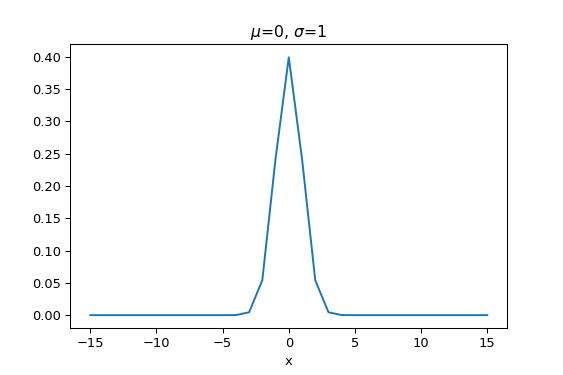

ThreadPool elapsed time : 0.73 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 1.64 seconds


In [580]:
gaussian_kernel , params_gaus = timeSeries.gaussian(x=np.arange(-15,16,1),
                                                                  mu=0,
                                                                  sig=1,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks.T,
                                                         gaussian_kernel,
                                                         axis=0,
                                                         mode='same',
                                                         multicore_pref=True,
                                                         verbose=True)
neural_data = spks_conv[:,IsCell_ROIClassifier==True]

# Linear Regression Decoding
`input: TxN` ⟶ `linear regression model` ⟶ `output: Tx1`

### data exploration

visualize face rhythms output timeseries for regression

In [581]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


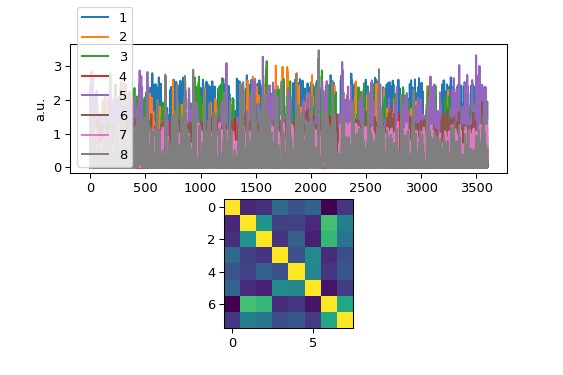

In [582]:
%matplotlib notebook

## just for plotting 
Fs = ops[()]['fs']

fig , axs = plt.subplots(2)
axs[0].plot(np.arange(camSignal_s2pInd.shape[0])/Fs, camSignal_s2pInd);
axs[0].legend(np.arange(camSignal_s2pInd.shape[1])+1)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('a.u.')

axs[1].imshow(decomposition.make_xcorrMat(camSignal_s2pInd));

### Do PCA

first run PCA on the inputs and outputs to orthogonalize them


look at scree plots and timeSeries of PCs

<IPython.core.display.Javascript object>


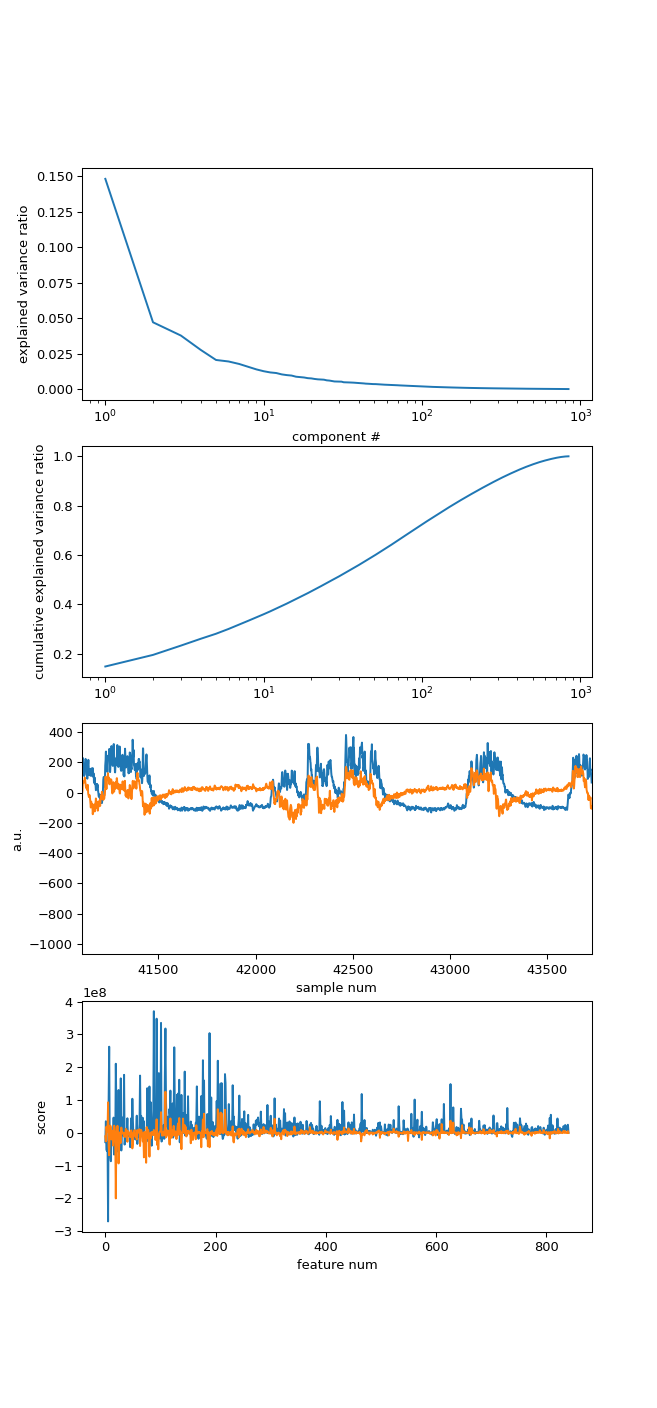

<IPython.core.display.Javascript object>


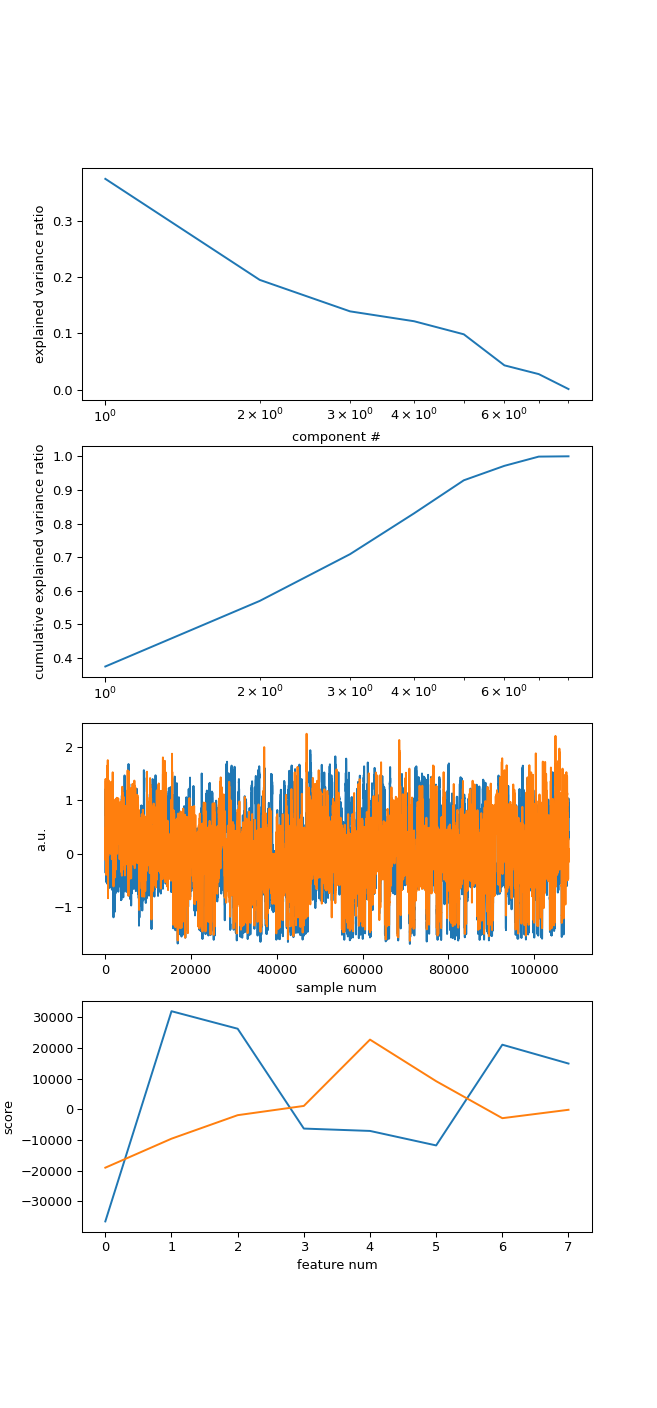

In [583]:
PCA_outputs_neural_temporalFactor , PCA_outputs_neural_neuronFactor , EV_ratio_neural = decomposition.simple_pca(neural_data,
                                                                                               n_components=neural_data.shape[1],
                                                                                               plot_pref=True)

PCA_outputs_behavioral , PCA_outputs_behavioral_componentFactor , EV_ratio_behavioral = decomposition.simple_pca(camSignal_s2pInd,
                                                                                           n_components=camSignal_s2pInd.shape[1],
                                                                                           plot_pref=True)

### Run Rastermap

In [670]:
import rastermap.mapping

# X = copy.deepcopy(neural_data[:,:].T)
# X = copy.deepcopy(spks)
X = scipy.stats.zscore(spks_conv[:,iscell[:,0]==1].T , axis=0)

{'n_components': 1, 'n_X': 100, 'alpha': 1., 'K': 1.,
                    'nPC': 200, 'constraints': 2, 'annealing': True, 'init': 'pca',
                    'start_time': 0, 'end_time': -1}
decomp = rastermap.mapping.Rastermap(n_components=1,
                             n_X=300,
                             nPC=400,
                             init='pca',
                             alpha=1.0,
                             K=1.0,
                             mode='basic',
                             verbose=True,
                             annealing=True,
                             constraints=2,)
embedding = decomp.fit_transform(X)

nmin 400
0.8365833759307861
22.015357494354248
23.13678288459778
23.151825428009033
(298, 300)
(154,)
1.0
time; iteration;  explained PC variance
0.02s     0        0.1663      2
0.34s    10        0.2500      7
0.75s    20        0.3119      17
1.18s    30        0.3828      42
1.69s    40        0.4408      67
2.04s    50        0.4822      92
2.32s    60        0.5121      117
2.59s    70        0.5367      142
2.87s    80        0.5607      167
3.16s    90        0.5796      192
3.49s    100        0.5971      217
3.82s    110        0.6149      242
4.11s    120        0.6330      267
4.39s    130        0.6506      292
4.70s    140        0.6551      298
5.00s    150        0.6551      298
5.08s   final      0.6551
5.09s upsampled    0.6551


In [673]:
X_crop = timeSeries.threshold(X,
                            thresh_max=3,
                            val_max=None
                             )

<IPython.core.display.Javascript object>


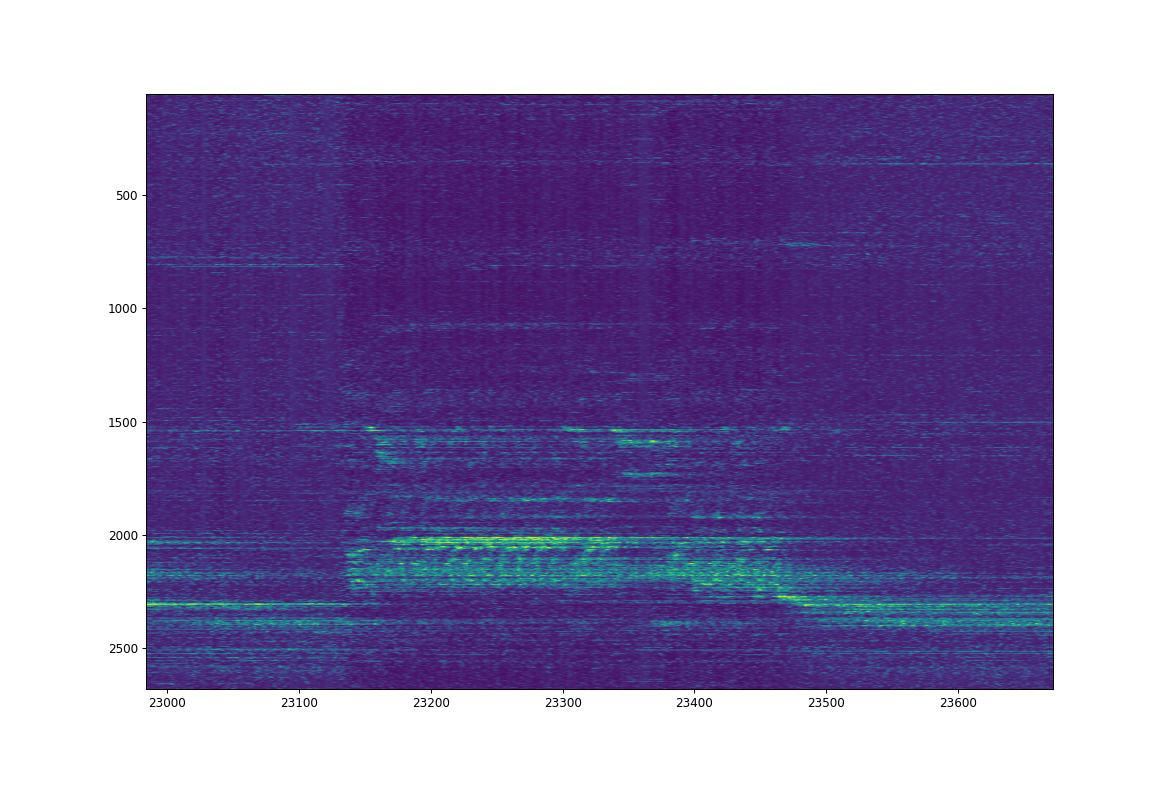

In [936]:
%matplotlib notebook
plt.figure()
plt.imshow(X_crop[decomp.isort , :] , aspect='auto')

<IPython.core.display.Javascript object>


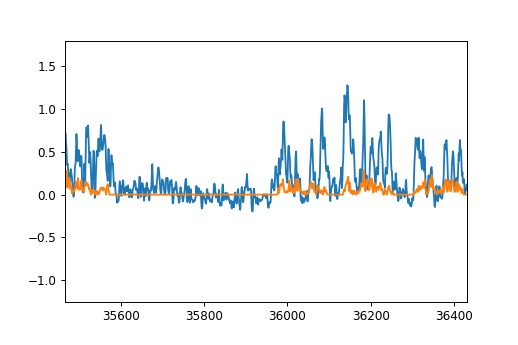

In [939]:
plt.figure()
plt.plot(np.mean(X_crop[decomp.isort[2070:2100],:] , axis=0))
plt.plot(ws_treadmill_S2pInd*1)
# plt.plot(ws_licks_bool_S2pInd*20)

In [1219]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules.spectral import mtaper_specgram, butter_bandpass, butter_bandpass_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


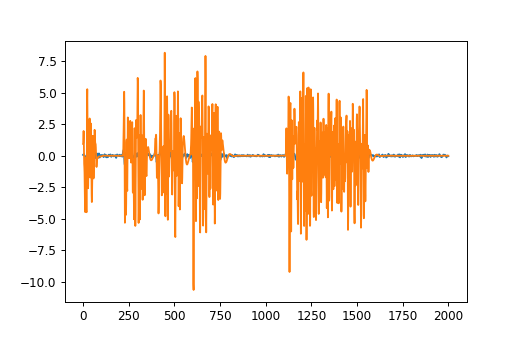

<IPython.core.display.Javascript object>


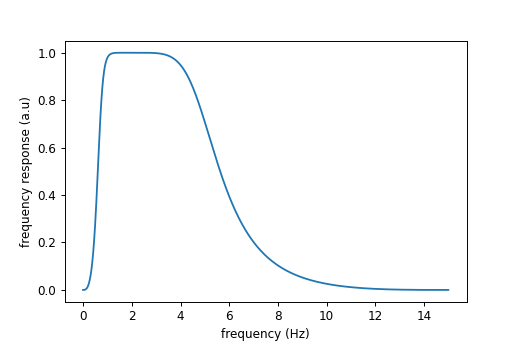

<IPython.core.display.Javascript object>


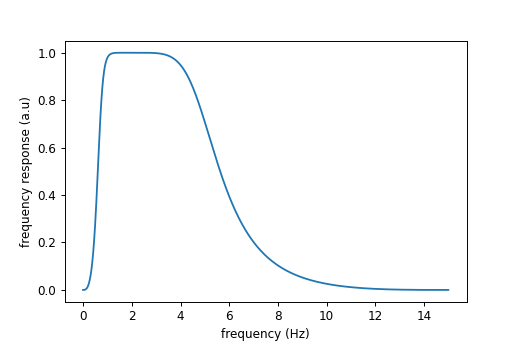

In [942]:

# Sample rate and desired cutoff frequencies (in Hz).
fs = ops[()]['fs']
lowcut = 0.7
highcut = 5.0

input_signal1 = copy.deepcopy(np.mean(X_crop[decomp.isort[2070:2100],:] , axis=0))
input_signal2 = copy.deepcopy(ws_treadmill_S2pInd)

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots()
for order in [3]:
    sig_filt_neural = butter_bandpass_filter(input_signal1,
                                      lowcut,
                                      highcut,
                                      fs,
                                      order=order,
                                      plot_pref=True)
    ax.plot(sig_filt_neural[46000:48000])
    
    sig_filt_treadmill = butter_bandpass_filter(input_signal2,
                                      lowcut,
                                      highcut,
                                      fs,
                                      order=order,
                                      plot_pref=True)
    ax.plot(sig_filt_treadmill[46000:48000]*50)

<IPython.core.display.Javascript object>


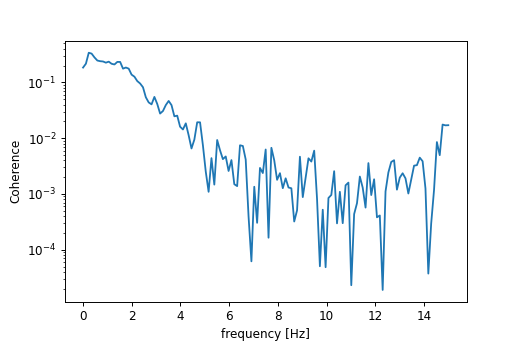

In [943]:
f, Cxy = scipy.signal.coherence(
                                sig_filt_neural,
                                sig_filt_treadmill,
                                ops[()]['fs'],
                                window='hann',
                                nperseg=None,
                                noverlap=None,
                                nfft=None,
                                detrend='constant',
                                axis=-1,
)
plt.figure()
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

In [1216]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules.timeSeries import threshold
from basic_neural_processing_modules.spectral import mtaper_specgram, butter_bandpass, butter_bandpass_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [950]:
# sig = copy.deepcopy(np.mean(X_crop[decomp.isort[1250:2000],:] , axis=0))
sig = copy.deepcopy(sig_filt_neural)


In [951]:
nw = 0.5 # Time-bandwidth product
ntapers = 4 # Number of tapers (None to set to 2 * nw -1)
win_len = 0.3 # Window length in seconds
win_overlap = win_len*0.9 # Window overlap in seconds
freq_res_frac = 1 # frequency resolution fraction. generates nfft. nfft= freq_resolution_frac * round(win_len * fs). 1.
fs = ops[()]['fs'] # Sampling rate
                    
f, t, S_full =  mtaper_specgram(
                        sig,
                        nw=nw,
                        ntapers=ntapers,
                        win_len=win_len,
                        win_overlap=win_overlap,
                        fs=fs,
                        freq_res_frac=freq_res_frac,
                        clip=None,
)

<IPython.core.display.Javascript object>


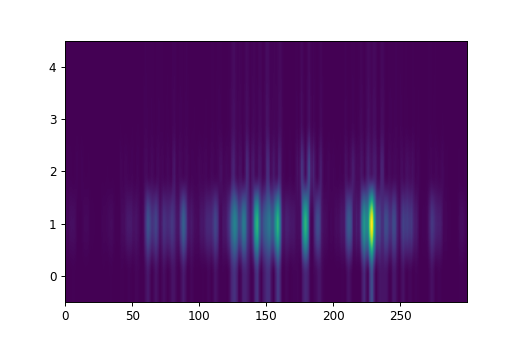

In [952]:
S_toPlot = threshold(S_full, thresh_max=2)**2
plt.figure()
plt.imshow(S_full[:,900:1200] , aspect='auto' , origin='lower')

<IPython.core.display.Javascript object>


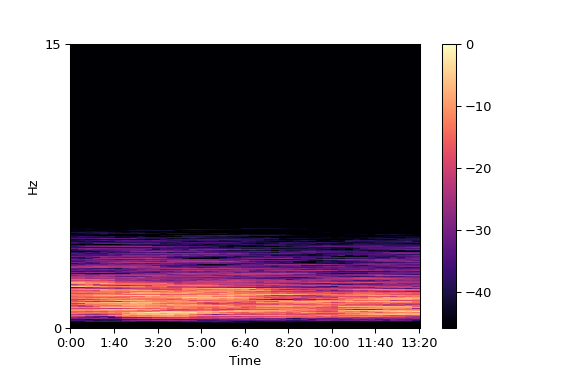

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-0.19/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode,

In [698]:
# Plot the spectrum
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full**1, ref=np.max),
                               y_axis='log', x_axis='time', sr=ops[()]['fs'], ax=ax)

fig.colorbar(img, ax=ax);

In [909]:
import pywt
print(pywt.families(short=True))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


In [1010]:
import pywt

plotRange = np.arange(300,1600)
sig = copy.deepcopy(sig_filt_neural)

scales = range(1,36)
waveletname = 'cmor0.5-1.0'

coeff, freq = pywt.cwt(sig, scales, waveletname, sampling_period=1/fs)
coeff2, freq2 = pywt.cwt(coeff**2, scales, waveletname, sampling_period=1/fs, axis=1)
# pywt.scale2frequency(wavelet, scale, precision=8)

fig, ax = plt.subplots(8)
for ii in range(8):
    ax[ii].imshow(np.abs(coeff2[ii*4,:,:])[:,plotRange]**2, aspect='auto', origin='upper')

In [1037]:
from kymatio.numpy import Scattering1D

sig = copy.deepcopy(sig_filt_neural)

T = sig.shape[-1]
J = 9
Q = 16

scattering = Scattering1D(J, T, Q)

S_scat = scattering(sig)

In [1038]:
meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

<IPython.core.display.Javascript object>


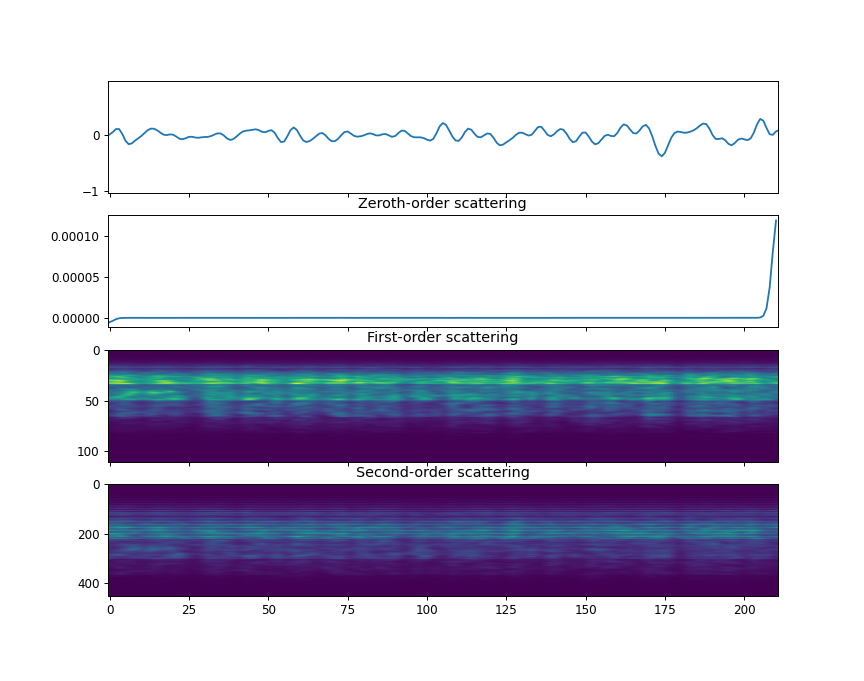

Text(0.5, 1.0, 'Second-order scattering')

In [1039]:
fig, axs = plt.subplots(4, sharex=True)

axs[0].plot(sig)

axs[1].plot(S_scat[order0][0])
axs[1].set_title('Zeroth-order scattering')
axs[2].imshow(S_scat[order1] , aspect='auto')
axs[2].set_title('First-order scattering')
axs[3].imshow(S_scat[order2] , aspect='auto')
axs[3].set_title('Second-order scattering')

<IPython.core.display.Javascript object>


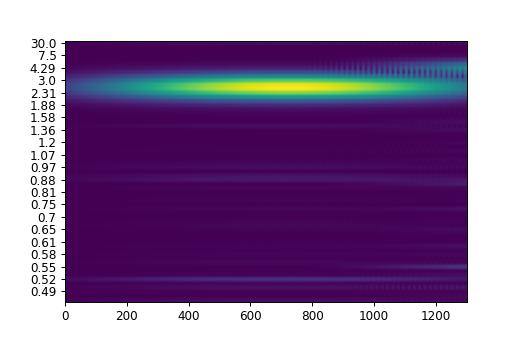

<IPython.core.display.Javascript object>


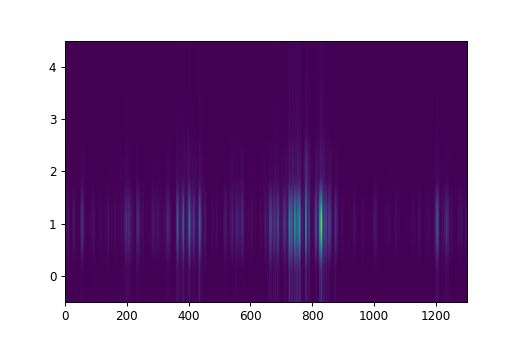

<IPython.core.display.Javascript object>


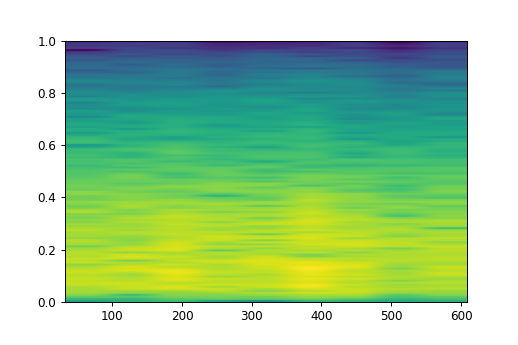

<IPython.core.display.Javascript object>


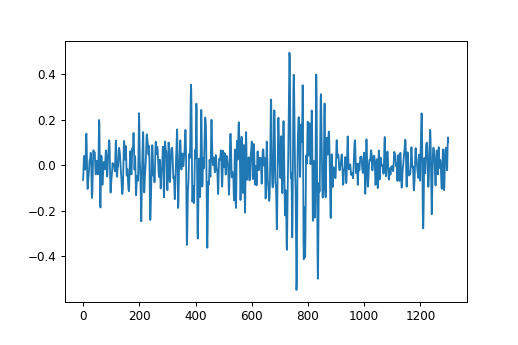

<IPython.core.display.Javascript object>


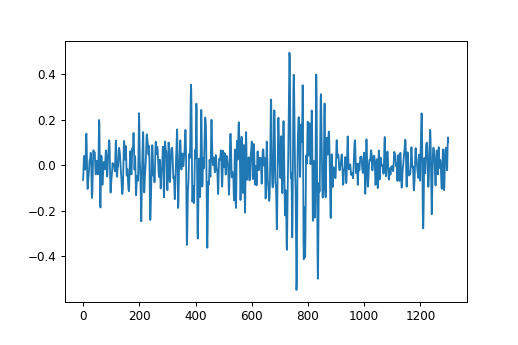

In [1054]:
ticks_toUse = np.arange(0,len(freq) ,3)    
fig, ax = plt.subplots()
ax.imshow(np.abs(coeff)[:,plotRange], aspect='auto', origin='upper')
ax.set_yticks(ticks_toUse)
ax.set_yticklabels(np.round(freq[ticks_toUse],2))

plt.figure()
plt.imshow(S_full[:,plotRange] , aspect='auto' , origin='lower')
plt.figure()
plt.specgram(sig[plotRange])
plt.figure()
plt.plot(sig[plotRange])
plt.figure()
plt.plot(sig[plotRange])

Cloning git repository at  https://github.com/Jakobovski/free-spoken-digit-dataset.git


<IPython.core.display.Javascript object>


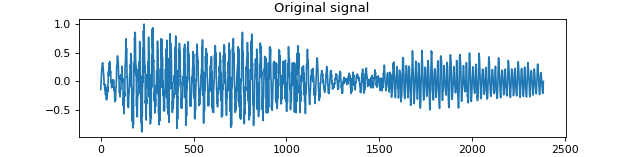

<IPython.core.display.Javascript object>


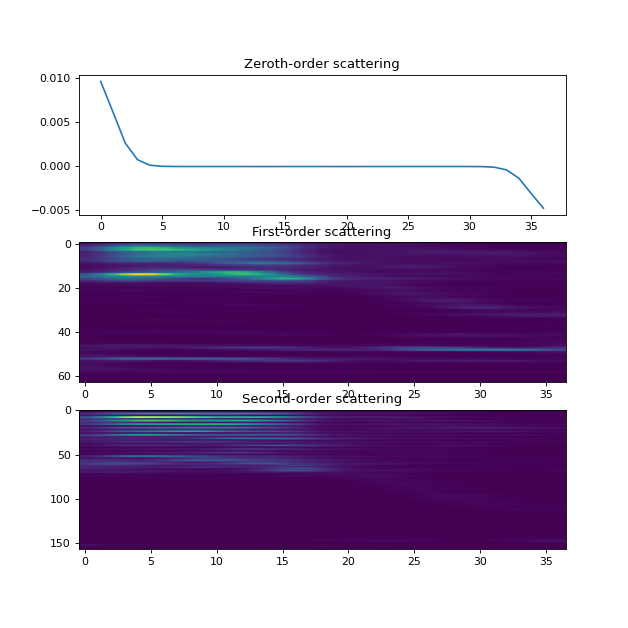

In [1256]:
"""
Compute the scattering transform of a speech recording
======================================================
This script loads a speech signal from the free spoken digit dataset (FSDD)
of a man pronouncing the word "zero," computes its scattering transform, and
displays the zeroth-, first-, and second-order scattering coefficients.
"""

###############################################################################
# Preliminaries
# -------------
#
###############################################################################
# To handle audio file I/O, we import `os` and `scipy.io.wavfile`.

import numpy as np
import os
import scipy.io.wavfile

###############################################################################
# We import `matplotlib` to plot the calculated scattering coefficients.

import matplotlib.pyplot as plt

###############################################################################
# Finally, we import the `Scattering1D` class from the `scattering` package and
# the `fetch_fsdd` function from `scattering.datasets`. The `Scattering1D`
# class is what lets us calculate the scattering transform, while the
# `fetch_fsdd` function downloads the FSDD, if needed.

from kymatio.numpy import Scattering1D
from kymatio.datasets import fetch_fsdd

###############################################################################
# Scattering setup
# ----------------
# First, we download the FSDD (if not already downloaded) and read in the
# recording `0_jackson_0.wav` of a man pronouncing the word "zero".

info_dataset = fetch_fsdd(verbose=True)

file_path = os.path.join(info_dataset['path_dataset'], sorted(info_dataset['files'])[0])
_, x = scipy.io.wavfile.read(file_path)

###############################################################################
# Once the recording is in memory, we normalize it.

x = x / np.max(np.abs(x))

###############################################################################
# We are now ready to set up the parameters for the scattering transform.
# First, the number of samples, `T`, is given by the size of our input `x`.
# The averaging scale is specified as a power of two, `2**J`. Here, we set
# `J = 6` to get an averaging, or maximum, scattering scale of `2**6 = 64`
# samples. Finally, we set the number of wavelets per octave, `Q`, to `16`.
# This lets us resolve frequencies at a resolution of `1/16` octaves.

T = x.shape[-1]
J = 6
Q = 16

###############################################################################
# Finally, we are able to create the object which computes our scattering
# transform, `scattering`.

scattering = Scattering1D(J, T, Q)

###############################################################################
# Compute and display the scattering coefficients
# -----------------------------------------------
# Computing the scattering transform of a signal is achieved using the
# `__call__` method of the `Scattering1D` class. The output is an array of
# shape `(C, T)`. Here, `C` is the number of scattering coefficient outputs,
# and `T` is the number of samples along the time axis. This is typically much
# smaller than the number of input samples since the scattering transform
# performs an average in time and subsamples the result to save memory.

Sx = scattering(x)

###############################################################################
# To display the scattering coefficients, we must first identify which belong
# to each order (zeroth, first, or second). We do this by extracting the `meta`
# information from the scattering object and constructing masks for each order.

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

###############################################################################
# First, we plot the original signal `x`.

plt.figure(figsize=(8, 2))
plt.plot(x)
plt.title('Original signal')

###############################################################################
# We now plot the zeroth-order scattering coefficient, which is simply an
# average of the original signal at the scale `2**J`.

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(Sx[order0][0])
plt.title('Zeroth-order scattering')

###############################################################################
# We then plot the first-order coefficients, which are arranged along time
# and log-frequency.

plt.subplot(3, 1, 2)
plt.imshow(Sx[order1], aspect='auto')
plt.title('First-order scattering')

###############################################################################
# Finally, we plot the second-order scattering coefficients. These are also
# organized aling time, but has two log-frequency indices: one first-order
# frequency and one second-order frequency. Here, both indices are mixed along
# the vertical axis.

plt.subplot(3, 1, 3)
plt.imshow(Sx[order2], aspect='auto')
plt.title('Second-order scattering')

###############################################################################
# Display the plots!

plt.show()


<IPython.core.display.Javascript object>


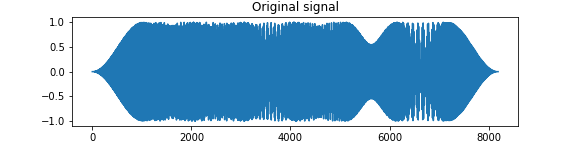

<IPython.core.display.Javascript object>


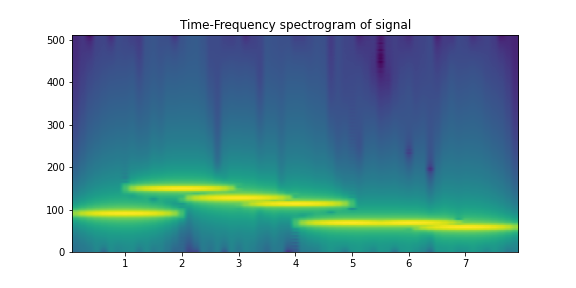

<ipython-input-1189-a3cd71ce0bc1>:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


<IPython.core.display.Javascript object>


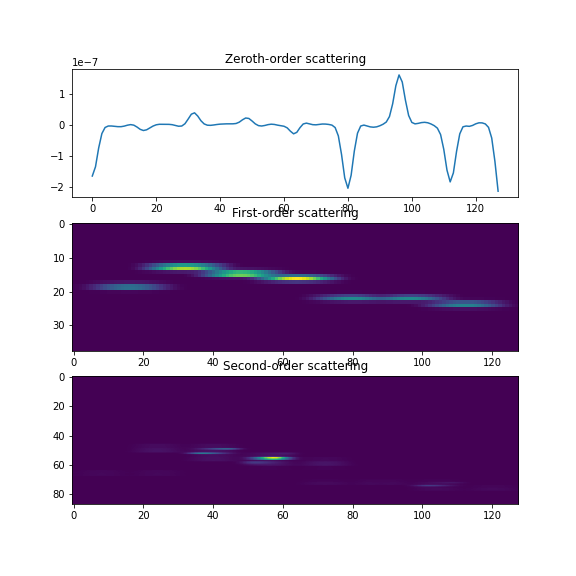

In [1189]:
"""
Compute the scattering transform of a synthetic signal
======================================================

In this example we generate a harmonic signal of a few different frequencies
and analyze it with the 1D scattering transform.
"""


###############################################################################
# Import the necessary packages
# -----------------------------
from kymatio.numpy import Scattering1D
import matplotlib.pyplot as plt
import numpy as np


###############################################################################
# Write a function that can generate a harmonic signal
# ----------------------------------------------------
# Let's write a function that can generate some simple blip-type sounds with
# decaying harmonics. It will take four arguments: T, the length of the output
# vector; num_intervals, the number of different blips; gamma, the exponential
# decay factor of the harmonic; random_state, a random seed to generate
# random pitches and phase shifts.
# The function proceeds by splitting the time length T into intervals, chooses
# base frequencies and phases, generates sinusoidal sounds and harmonics,
# and then adds a windowed version to the output signal.
def generate_harmonic_signal(T, num_intervals=4, gamma=0.9, random_state=42):
    """
    Generates a harmonic signal, which is made of piecewise constant notes
    (of random fundamental frequency), with half overlap
    """
    rng = np.random.RandomState(random_state)
    num_notes = 2 * (num_intervals - 1) + 1
    support = T // num_intervals
    half_support = support // 2

    base_freq = 0.1 * rng.rand(num_notes) + 0.05
    phase = 2 * np.pi * rng.rand(num_notes)
    window = np.hanning(support)
    x = np.zeros(T, dtype='float32')
    t = np.arange(0, support)
    u = 2 * np.pi * t
    for i in range(num_notes):
        ind_start = i * half_support
        note = np.zeros(support)
        for k in range(1):
            note += (np.power(gamma, k) *
                     np.cos(u * (k + 1) * base_freq[i] + phase[i]))
        x[ind_start:ind_start + support] += note * window

    return x

###############################################################################
# Let's take a look at what such a signal could look like
# -------------------------------------------------------
T = 2 ** 13
x = generate_harmonic_signal(T)
plt.figure(figsize=(8, 2))
plt.plot(x)
plt.title("Original signal")

###############################################################################
# Spectrogram
# -----------
# Let's take a look at the signal spectrogram
plt.figure(figsize=(8, 4))
plt.specgram(x, Fs=1024)
plt.title("Time-Frequency spectrogram of signal")

###############################################################################
# Doing the scattering transform
# ------------------------------
J = 6
Q = 8

scattering = Scattering1D(J, T, Q)

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

Sx = scattering(x)

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(Sx[order0][0])
plt.title('Zeroth-order scattering')
plt.subplot(3, 1, 2)
plt.imshow(Sx[order1], aspect='auto')
plt.title('First-order scattering')
plt.subplot(3, 1, 3)
plt.imshow(Sx[order2], aspect='auto')
plt.title('Second-order scattering')

plt.show()

In [1437]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules.timeSeries import threshold
from basic_neural_processing_modules.spectral import mtaper_specgram, butter_bandpass, butter_bandpass_filter, simple_cwt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<ipython-input-1255-c1bf6c68f4ce>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


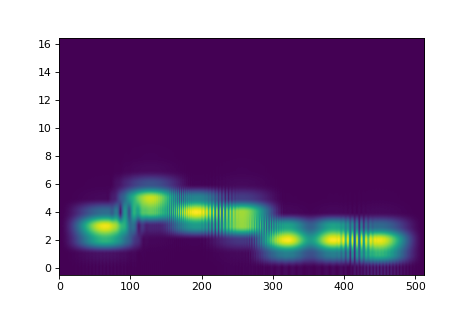

<IPython.core.display.Javascript object>


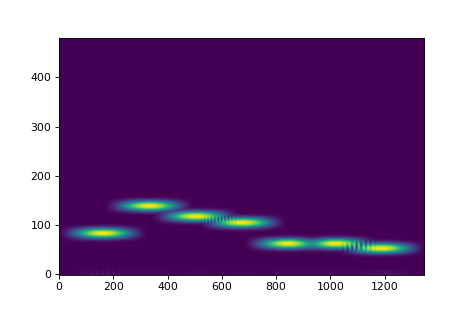

<IPython.core.display.Javascript object>


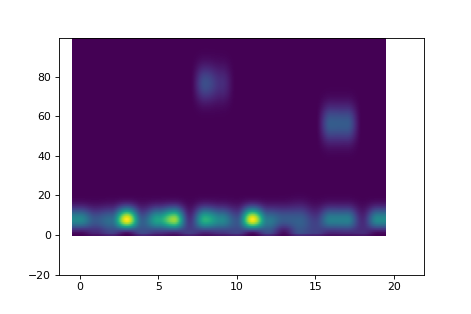

In [1255]:
nw = 2.5 # Time-bandwidth product
ntapers = 1 # Number of tapers (None to set to 2 * nw -1)
win_len = 4 # Window length in seconds
win_overlap = win_len*0.95 # Window overlap in seconds
freq_res_frac = 8 # frequency resolution fraction. generates nfft. nfft= freq_resolution_frac * round(win_len * fs). 1.
fs = 30 # Sampling rate

f, t, Zxx = scipy.signal.stft(x, fs, nperseg=32)
                    
f, t, S_full =  mtaper_specgram(
                        x,
                        nw=nw,
                        ntapers=ntapers,
                        win_len=win_len,
                        win_overlap=win_overlap,
                        fs=fs,
                        freq_res_frac=freq_res_frac,
                        clip=None,
                        mode='complex')
f, t, S_full2 =  mtaper_specgram(
                        np.abs(S_full),
                        nw=nw,
                        ntapers=ntapers,
                        win_len=win_len*2,
                        win_overlap=win_overlap,
                        fs=fs/2,
                        freq_res_frac=freq_res_frac,
                        clip=None,)

plt.figure()
plt.imshow(np.abs(Zxx) , aspect='auto' , origin='lower')
plt.figure()
plt.imshow(np.abs(S_full) , aspect='auto' , origin='lower')
plt.figure()
plt.imshow(np.abs(np.mean(S_full2, axis=0)) , aspect='auto', origin='lower')

<IPython.core.display.Javascript object>


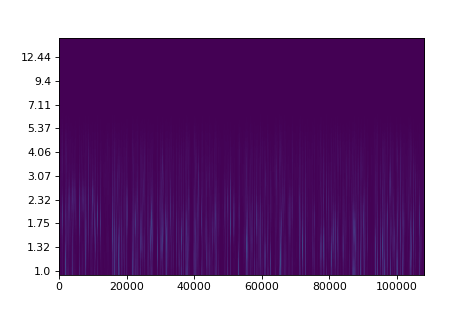

In [1441]:
sig = copy.deepcopy(sig_filt_neural)

freqs_toUse = np.logspace(np.log(fs/30), np.log(fs/2), 30, base=np.exp(1))
# freqs_toUse = np.array([1,3,4,5])
fs = ops[()]['fs']
wavelet_type = 'cmor'
bwf = 4 # bandwidth (frequency units)
cf = 1 # center frequency

coeff, freq = simple_cwt(sig, 
                         freqs_toUse=freqs_toUse,
                         fs=fs,
                         wavelet_type=wavelet_type,
                         bwf=bwf,
                         cf=cf,
                         psd_scaling=False,
                         plot_pref=False,
                         axis=-1)
coeff, freq = simple_cwt(sig)


## Regression

In [240]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import timeSeries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import plotting_helpers, cross_validation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### define inputs and outputs

In [14]:
import copy

n_behav_traces = camSignal_s2pInd.shape[1]
n_neurons = neural_data.shape[1]
Fs = ops[()]['fs']

# X = copy.deepcopy(np.single(neural_data)) # Use ROI timeseries as inputs
y = copy.deepcopy(np.single(neural_data)) # Use PCs as inputs
X = copy.deepcopy(np.single(PCA_outputs_behavioral)) # Use face rhythm factors as outputs

### prepare cross-validation

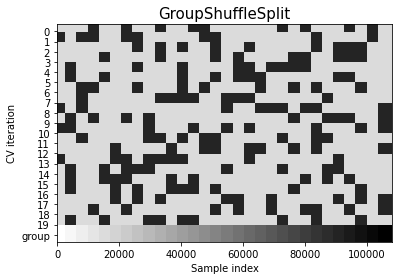

In [19]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
%matplotlib inline

group_len = 60*2 * Fs # seconds * Fs
n_splits = 20
test_size = 0.3

groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx = cross_validation.make_cv_indices(cv,
                                          groups,
                                          lw=20,
                                          plot_pref=True)

### prepare rolling shuffles

In [20]:
n_nonzero_rolls = 2

min_roll = 60*10*Fs
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_nonzero_rolls)))
n_rolls = n_nonzero_rolls + 1

### prepare regularization params

In [21]:
alphas = np.array([
    0.0001
#     0.001, 
#     0.002, 0.004, 0.008,
#     0.012, 0.02 ,
#     0.04 ,
#     0.08 ,
#     0.15 ,
#     0.3 ,
#     0.6,
#     1.0,
#     2.0,
#     4.0,
#     8.0,
#     16,
#     32,
#     64,
#     128
        ])

# alphas = np.array([
#     0.008
# ])

l1_ratios = np.array([
    1 ,
#     0.99 ,
#     0.95 ,
#     0.9 ,
#     0.7 ,
#     0.5 , 0.2 ,
#                       0.1 , 0.01
                     ])
l1_ratios = np.array([0])

### perform regression

In [18]:
pref_useGPU = True
if pref_useGPU:
    import cudf
    import cuml
    import cupy
    
    X = cupy.asarray(X)
    y = cupy.asarray(y)

In [23]:
import gc
n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)

len_train = len(cv_idx[0][0])
len_test = len(cv_idx[0][1])

n_y = y.shape[1]

# y = np.zeros((X.shape[0] , n_behav_traces , n_rolls))
theta_FF = np.ones((X.shape[1] , n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
R_train = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))
R_test = np.zeros((n_y,n_splits , n_rolls , n_alphas , n_l1Ratios))
y_reconstructed_FF = np.zeros((X.shape[0] , n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
y_train_reconstructed_FF = np.zeros((len_train , n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
y_test_reconstructed_FF = np.zeros((len_test , n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))

for iter_factor in range(n_y):
# for iter_factor in np.array([5]):
    for iter_roll in range(n_rolls):
#         y[:, iter_factor, iter_roll] = np.roll(y[:,iter_factor] , rolls[iter_roll])
        y_iter = np.roll(y[:,iter_factor] , rolls[iter_roll])

    #     X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    #         X, y[:,iter_factor], test_size=0.3, random_state=0)

        for iter_cv, (idx_train , idx_test) in enumerate(cv_idx):
            X_train = X[idx_train,:]
            y_train = y_iter[idx_train]
            X_test = X[idx_test,:]
            y_test = y_iter[idx_test]
            
            for iter_alpha , alpha in enumerate(alphas):
                for iter_l1Ratio , l1_ratio in enumerate(l1_ratios):

#                     ### SKLEARN regression
#                     clf = sklearn.linear_model.Lasso(alpha=alpha,
#                                                      fit_intercept=True,
#                                                      normalize=False,
#                                                      precompute=False,
#                                                      copy_X=True,
#                                                      max_iter=1000,
#                                                      tol=0.0001,
#                                                      warm_start=True,
#                                                      positive=False,
#                                                      random_state=None,
#                                                      selection='cyclic'
#                                                     )
                    
#                     clf = sklearn.linear_model.ElasticNet(alpha=alpha,
#                                                           l1_ratio=l1_ratio,
#                                                           fit_intercept=True,
#                                                           normalize=False,
#                                                           precompute=False,
#                                                           max_iter=1000,
#                                                           copy_X=True,
#                                                           tol=0.0001,
#                                                           warm_start=True,
#                                                           positive=False,
#                                                           random_state=None,
#                                                           selection='cyclic'
#                                                          )
                    
#                     clf = sklearn.linear_model.SGDRegressor(loss='squared_loss',
#                                                             penalty='elasticnet',
#                                                             alpha=0.0001,
#                                                             l1_ratio=0.15,
#                                                             fit_intercept=True,
#                                                             max_iter=1000, 
#                                                             tol=0.001,
#                                                             shuffle=True,
#                                                             verbose=0,
# #                                                             epsilon=0.1,
# #                                                             random_state=None, 
#                                                             learning_rate='invscaling', 
#                                                             eta0=0.01, 
#                                                             power_t=0.25, 
# #                                                             early_stopping=False,
# #                                                             validation_fraction=0.1, 
# #                                                             n_iter_no_change=5,
#                                                             warm_start=True,
#                                                             average=False
#                                                            )


                    clf = cuml.linear_model.Lasso(alpha=alpha,
                                                        fit_intercept=True,
                                                        normalize=False,
                                                        max_iter=1000,
                                                        tol=0.0001,
                                                        selection='cyclic',
                                                        handle=None,
                                                        output_type='numpy',
                                                        verbose=False
                                                        )
                    
                    clf.fit(X_train , y_train )
#                     theta_FF[:, iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = clf.coef_
                    theta_FF[:, iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy(clf.coef_)


        #             theta_FF[:, iter_factor, iter_cv, iter_roll] = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

                    y_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]       = cupy.asnumpy(clf.predict(X))
                    y_train_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy(clf.predict(X_train))
                    y_test_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]  = cupy.asnumpy(clf.predict(X_test))
                

                    R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy((np.corrcoef(y_train_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio], y_train))[1,0])
#                     print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , train  R: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , train R^2: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)}')

                    R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy((np.corrcoef(y_test_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio], y_test))[1,0])
#                     print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , test   R: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , test  R^2: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)} \n')

            gc.collect()

In [61]:
# save regression outputs

cv_params = {
                    "rolls": rolls,
                    "group_len": group_len,
                    "groups": groups,
                    "n_groups": n_groups,
                    "n_splits": n_splits,
                    "test_size": test_size,
                    "min_roll": min_roll,
                    "cv_idx": cv_idx
}

regression_run = {
                    "alphas": alphas,
                    "l1_ratios": l1_ratios,
                    "IsCell_ROIClassifier": IsCell_ROIClassifier,
                    "X": X,
                    "y": y,
                    "theta_FF":theta_FF,
                    "y_reconstructed_FF": y_reconstructed_FF,
                    "y_train_reconstructed_FF": y_train_reconstructed_FF,
                    "y_test_reconstructed_FF": y_test_reconstructed_FF,
                    "R_train": R_train,
                    "R_test": R_test,
                    "cv_params": cv_params,
#                     "linear_regression_model": clf
}


In [62]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_save = 'regression_run_'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
# np.save(path_save , regression_run)
import joblib
joblib.dump(regression_run , path_save, protocol=4)

Saving to: /media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis/regression_run_20210507.npy


['/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis/regression_run_20210507.npy']

In [804]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import h5_handling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_load = 'regression_run_20210503'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + fileSuffix_load)
# path_load = dir_load / fileName_load

regression_run = np.load(path_load , allow_pickle=True)
# regression_run = joblib.load(path_load)

alphas = regression_run[()]['alphas']
l1_ratios = regression_run[()]['l1_ratios']
IsCell_ROIClassifier = regression_run[()]['IsCell_ROIClassifier']
l1_ratios = regression_run[()]['l1_ratios']
X = regression_run[()]['X']
y = regression_run[()]['y']
theta_FF = regression_run[()]['theta_FF']
y_reconstructed_FF = regression_run[()]['y_reconstructed_FF']
y_train_reconstructed_FF = regression_run[()]['y_train_reconstructed_FF']
y_test_reconstructed_FF = regression_run[()]['y_test_reconstructed_FF']
R_train = regression_run[()]['R_train']
R_test = regression_run[()]['R_test']
cv_params = regression_run[()]['cv_params']
clf = regression_run[()]['linear_regression_model']

rolls = cv_params['rolls']
group_len = cv_params['group_len']
groups = cv_params['groups']
n_groups = cv_params['n_groups']
n_splits = cv_params['n_splits']
test_size = cv_params['test_size']
min_roll = cv_params['min_roll']
cv_idx = cv_params['cv_idx']

<IPython.core.display.Javascript object>


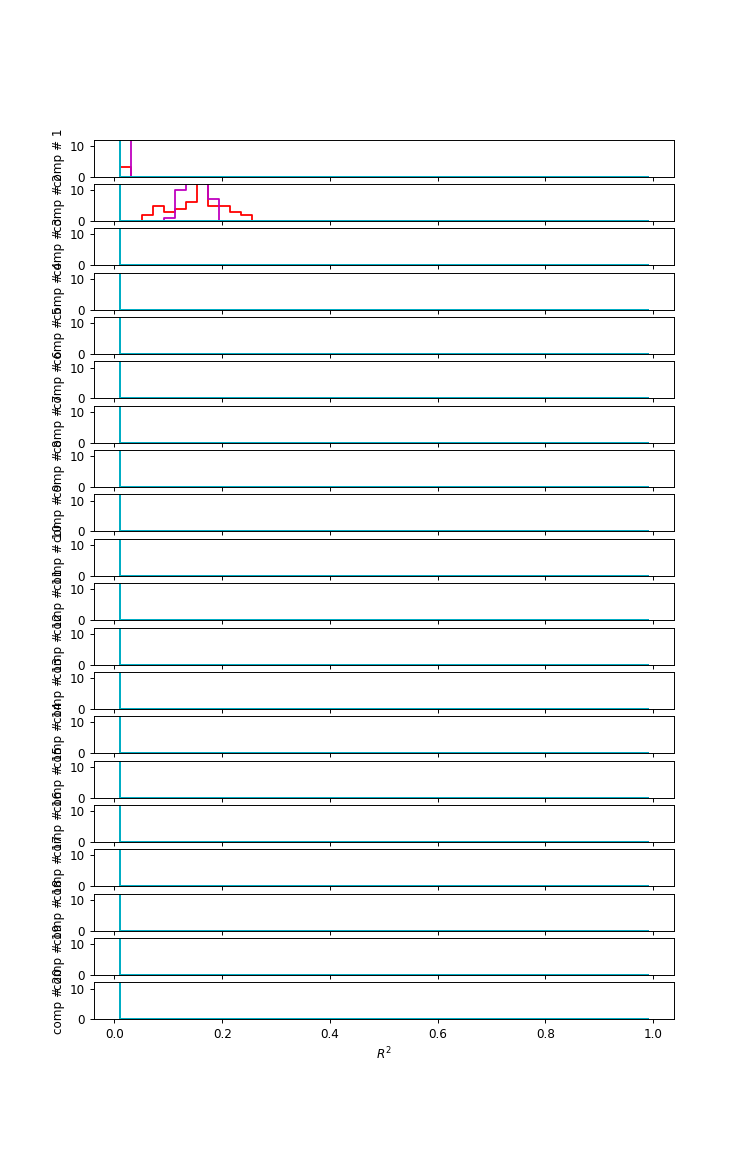

In [145]:
import numpy
alf = 0
l1R = 0

n_bins = 50
ylim = [0, 12]
n_rolls = len(rolls)

%matplotlib notebook
fig, axs = plt.subplots(20, sharex=True, sharey=True)
comps_toUse = np.arange(20)
for i_comp, comp in enumerate(comps_toUse):

    for i_shuf,vals in enumerate(np.arange(n_rolls)):
#         data = R_test[comp,:,i_shuf,alf,l1R]**2
        data = R_test[comp,:,i_shuf,alf,l1R]**2
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'r')
        else:
            axs[i_comp].step(edges_centers , counts , 'b')
        
#         data = R_train[comp,:,i_shuf,alf,l1R]**2
        data = R_train[comp,:,i_shuf,alf,l1R]**2
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2
        
        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'm')
        else:
            axs[i_comp].step(edges_centers , counts , 'c')
        
        plt.xlabel('$R^2$')
        axs[i_comp].set_ylabel(f'comp # {comp+1}')
        axs[i_comp].set_ylim(ylim)
#         axs.subplot(sharey = ax1)
#         plt.legend(('test','train','test shuffle','train shuffle'))


<IPython.core.display.Javascript object>


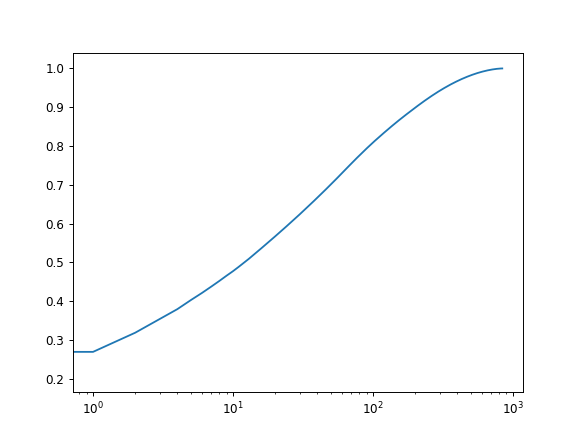

In [104]:
plt.figure()
plt.plot(np.cumsum(EV_ratio_neural))
plt.xscale('log')

<IPython.core.display.Javascript object>


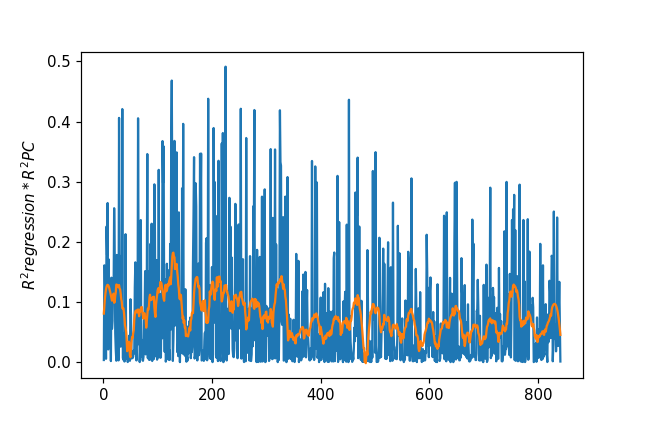

total explained variance: 0.15549592939132106


<IPython.core.display.Javascript object>


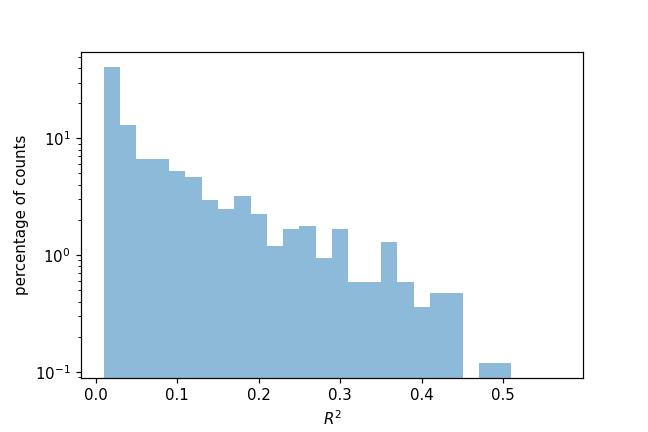

In [55]:
import scipy.signal
%matplotlib notebook
R_test.shape
test = np.mean(R_test[:,:,0,0,0] , axis=1)
plt.figure()
# plt.plot(test**2 * EV_ratio_behavioral)
# plt.plot(np.arange(len(EV_ratio_neural))+1 , test**2 * EV_ratio_neural)
plt.plot(np.arange(len(EV_ratio_neural))+1 , test**2)
plt.plot(np.arange(len(EV_ratio_neural))+1 , scipy.signal.savgol_filter(test**2,31,3))
plt.ylabel('$R^2 regression  *  R^2 PC$')
print(f'total explained variance: {np.sum(test**2 * EV_ratio_neural)/0.55}')
# plt.xscale('log')

bins = np.arange(0,0.6,0.02)
counts , edges = np.histogram(test**2, bins)
edges_centers = (edges[:-1] + edges[1:]) / 2
fig , axs = plt.subplots(1)
axs.fill_between(edges_centers , (counts/len(test))*100 , step="post", alpha=0.5)
axs.set_ylabel('percentage of counts')
axs.set_xlabel('$R^2$')
axs.set_yscale('log')

<IPython.core.display.Javascript object>


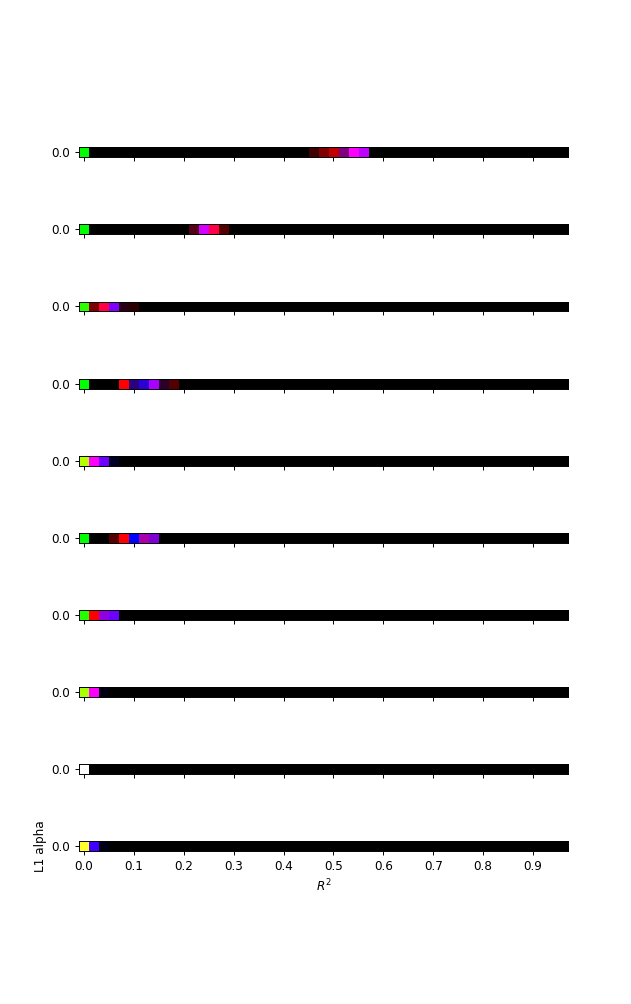

In [96]:
n_alphas = R_test.shape[3]
n_fac = R_test.shape[0]
n_fac = 10

fig, axs = plt.subplots(n_fac, sharex=True, sharey=False)

for i_fac in range(n_fac):

    im = np.zeros((n_alphas, len(edges_centers),3))
    for alf in range(n_alphas):
        data = R_test[i_fac,:,0,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,0] = counts

        data = R_test[i_fac,:,1,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,1] = counts
        
        data = R_train[i_fac,:,0,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,2] = counts

    im_norm = np.zeros((n_alphas, len(edges_centers),3))
    im_norm[:,:,0] = im[:,:,0] / np.max(im[:,:,0])
    im_norm[:,:,1] = im[:,:,1] / np.max(im[:,:,1])
    im_norm[:,:,2] = im[:,:,2] / np.max(im[:,:,2])
    axs[i_fac].imshow(im_norm)
    
    ticks_toUse = np.arange(0,len(edges_centers) , 5)
    axs[i_fac].set_xticks(ticks_toUse)
    axs[i_fac].set_xticklabels(np.round(edges_centers[ticks_toUse],1))
    
    ticks_toUse = np.arange(0,n_alphas ,3)    
    axs[i_fac].set_yticks(ticks_toUse)
    axs[i_fac].set_yticklabels(np.round(alphas[ticks_toUse],3))
    
    plt.xlabel('$R^2$')
    plt.ylabel('L1 alpha')

<IPython.core.display.Javascript object>


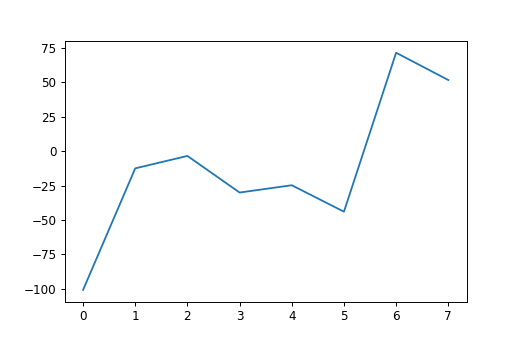

8


In [131]:
%matplotlib notebook

factors_toShow = np.array([1]) # 1-indexed
plt.figure()
for ii in factors_toShow:
    
    weights = theta_FF[0:,ii-1,0,0,0,0]
    if ii==2:
        weights=weights*-1
    print(np.sum(weights!=0))

    plt.plot(weights)
#     plt.plot(scipy.signal.savgol_filter(weights , 101 , 3));

In [125]:
np.array(y.get()).shape

(108000, 841)

<IPython.core.display.Javascript object>


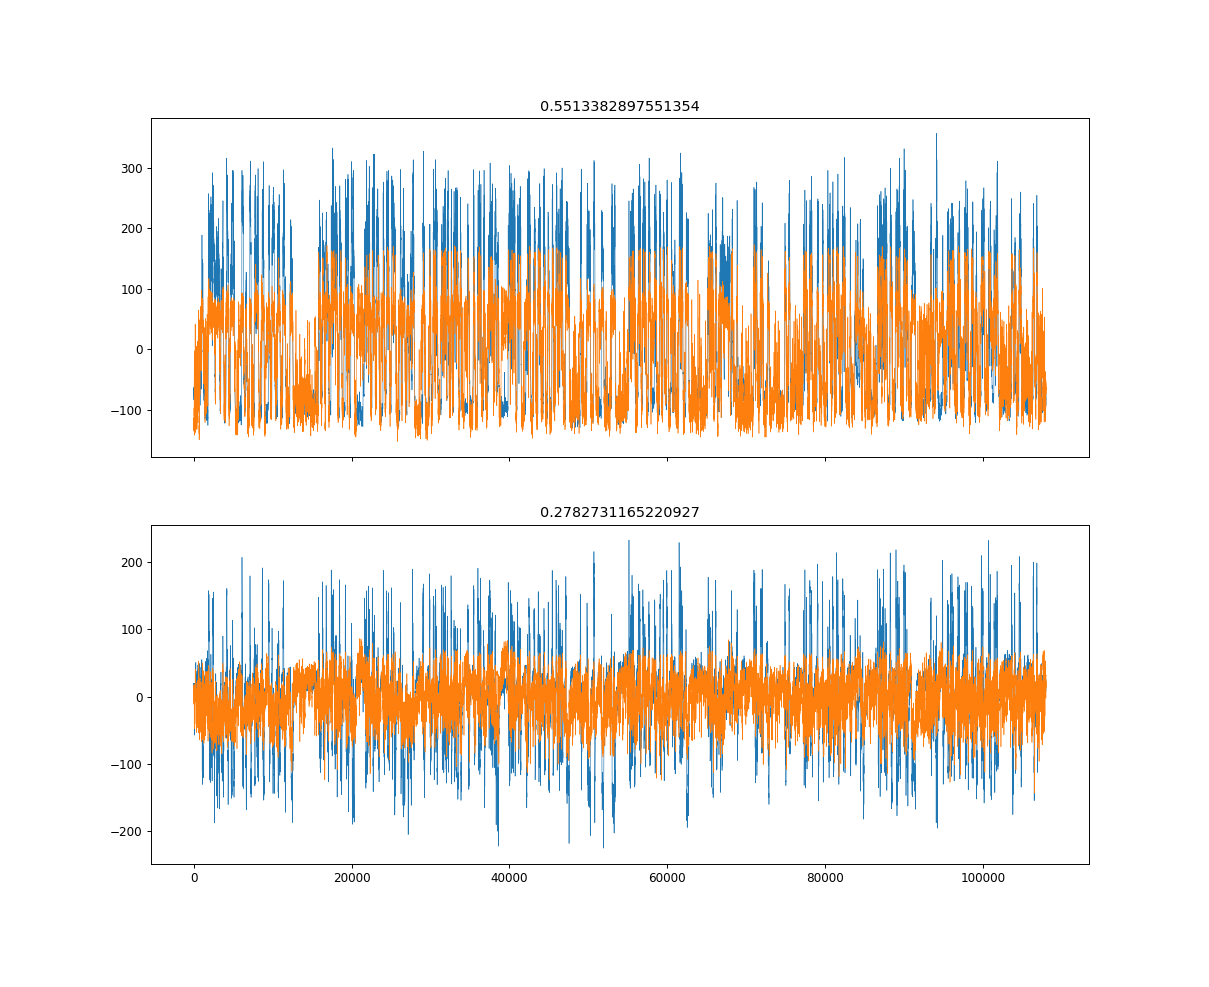

<IPython.core.display.Javascript object>


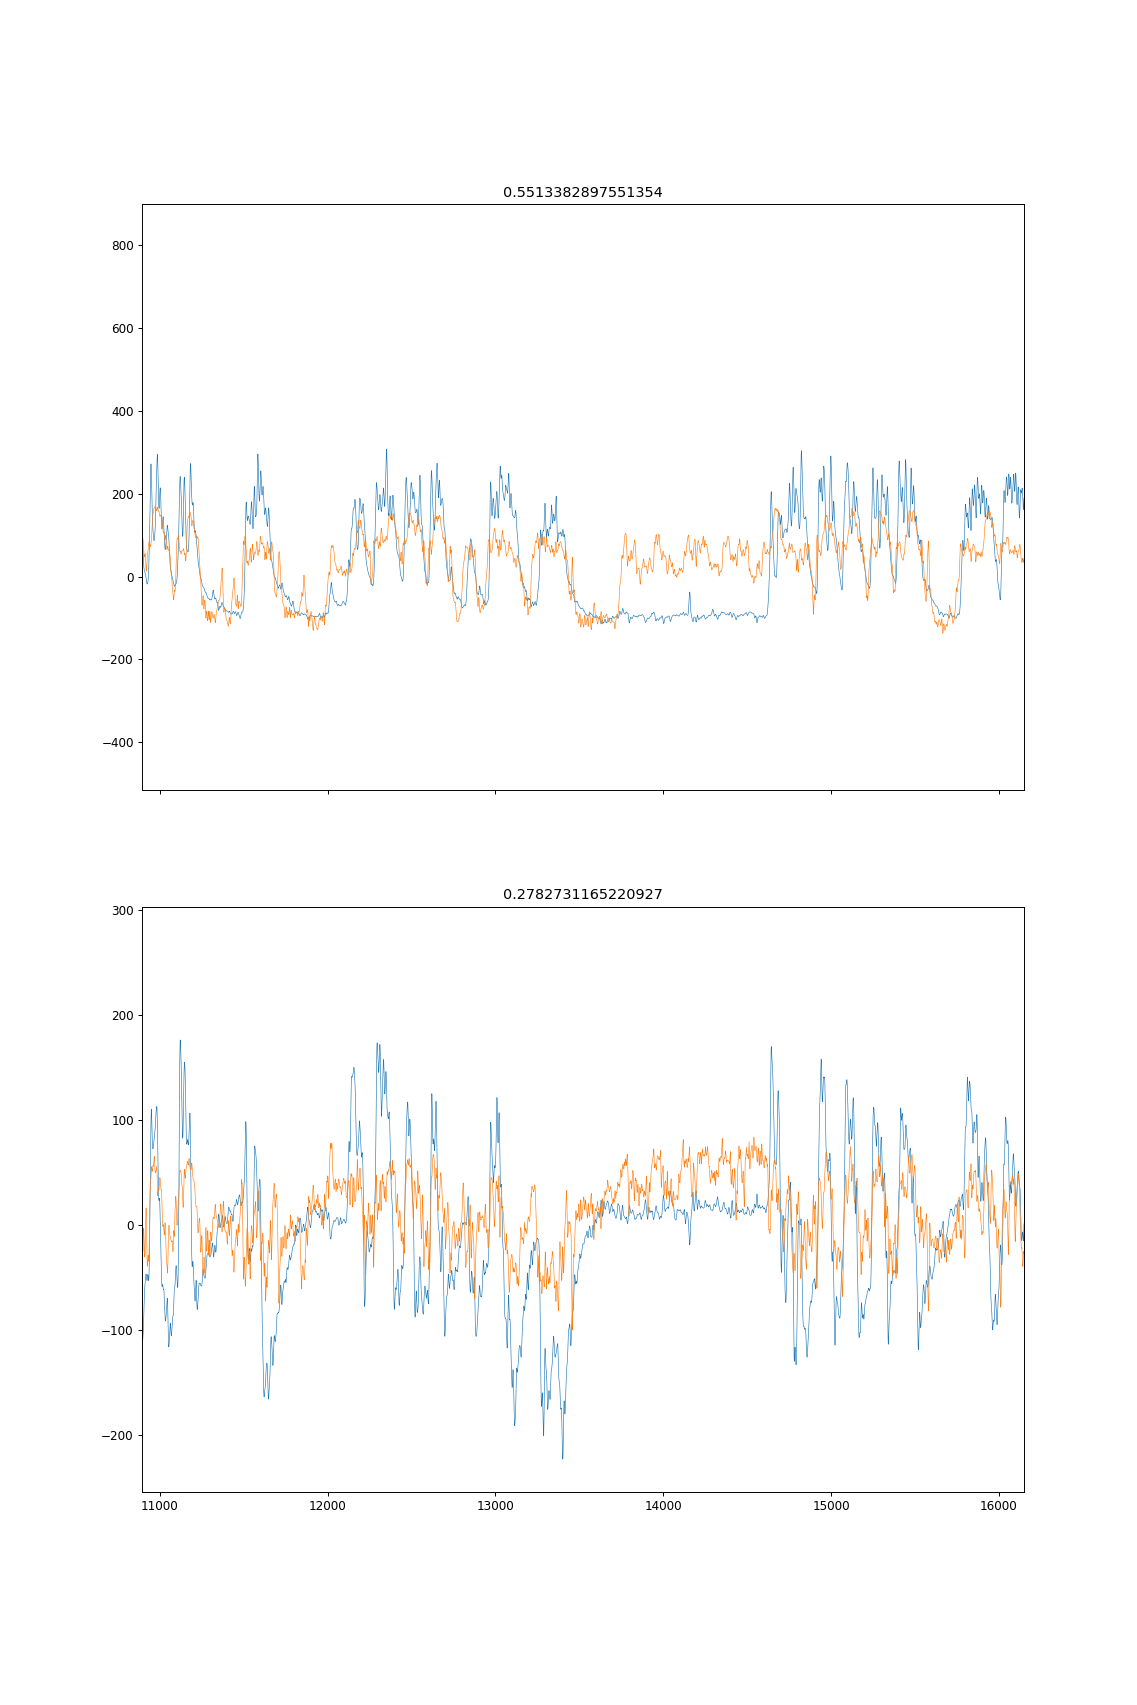

In [130]:
# full time series
n_y = 2
# if pref_useGPU==True:
#     y = y.get()
#     X = X.get()
fig, axs = plt.subplots(n_y, 1, sharex=True, sharey=False)
for iter_factor in range(n_y):
    axs[iter_factor].plot(y[:,iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(y_reconstructed_FF[:,iter_factor,0,0,0,0] , linewidth=0.5)
    axs[iter_factor].set_title(R_test[iter_factor,0,0,0,0]**2)
    
# held out test data
fig, axs = plt.subplots(n_y, 1, sharex=True, sharey=False)
for iter_factor in range(n_y):
    cv_idx_tmp = cv_idx[0]
    axs[iter_factor].plot(y[cv_idx_tmp[1],iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(y_reconstructed_FF[cv_idx_tmp[1],iter_factor,0,0,0,0] , linewidth=0.5)
    axs[iter_factor].set_title(R_test[iter_factor,0,0,0,0]**2)

In [15]:
# compare NMF(neural data) to FR(behavioral data)_temporal factors



In [23]:
manual_selection_vars = np.load('/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight/manual_selection_vars.npy' , allow_pickle=True)

In [27]:
manual_selection_vars[()].keys()

dict_keys(['toInclude_preExclusion', 'toExclude_manuallyClicked', 'predictions', 'output_activations', 'prob', 'toInclude_final', 'spatial_footprints_centered_toInclude', 'spatial_footprints_centered_crop_toInclude'])

In [31]:
IsCell_ROIClassifier2 = np.zeros(len(IsCell_ROIClassifier)+1)
IsCell_ROIClassifier2[:len(IsCell_ROIClassifier)] = IsCell_ROIClassifier
IsCell_ROIClassifier2.shape

(4870,)

In [32]:
IsCell_ROIClassifier = copy.deepcopy(IsCell_ROIClassifier2)

In [93]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor
from tqdm import tqdm

# num_factors = temporalFactors_s2pInd.shape[1]

X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)
X_input[X_input<0] = 0
# X_input /= np.std(X_input, axis=0)
# X_input = scipy.stats.zscore(X_input , axis=0)

# y_input = temporalFactors_s2pInd[:,:]

In [94]:
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
# y = copy.deepcopy(y_input)

<IPython.core.display.Javascript object>


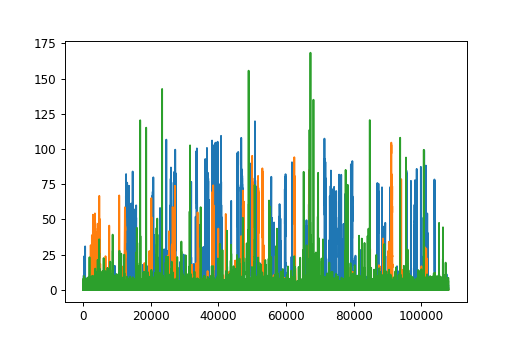

In [95]:
plt.figure()
plt.plot(X_input[:,np.array([0,1,800])])

In [191]:
fac_neuron2 = copy.deepcopy(fac_neuron)
fac_temp2 = copy.deepcopy(fac_temp)
rec_err2 = copy.deepcopy(rec_err)

In [96]:
import tensorly as tl
import tensorly.decomposition
import torch

In [97]:
tl.set_backend('pytorch')
cuda_device_number = torch.cuda.current_device()
cuda_device_number
X_input_tensor = tl.tensor(X_input, dtype=tl.float32, device=0, requires_grad=False)

In [98]:
from tqdm.notebook import trange, tqdm
n_repeats = 1
# ranks = np.array([15,16,17,18,19,20,21,22])
# ranks = np.arange(30)+1
ranks = np.array([8])

n_ranks = len(ranks)
n_neurons = X_input.shape[1]
n_timepoints = X_input.shape[0]

fac_neuron = list(np.zeros(n_ranks))
fac_temp = list(np.zeros(n_ranks))
rec_err = list(np.zeros(n_ranks))
for i_rank, rank in enumerate(tqdm(ranks)):
    fac_neuron[i_rank] = np.zeros((n_neurons , rank , n_repeats))
    fac_temp[i_rank] = np.zeros((n_timepoints , rank , n_repeats))
    rec_err[i_rank] = np.zeros((n_repeats))
    for i_rep in trange(n_repeats):
        model = sklearn.decomposition.NMF(n_components=rank,
                                          init='random',
                                          solver='cd',
                                          beta_loss='frobenius',
                                          tol=0.000001,
                                          max_iter=10000,
                                          random_state=None,
                                          alpha=0.0,
                                          l1_ratio=0.0,
                                          verbose=False,
                                          shuffle=False,
                                          regularization='both'
                                         )

        fac_neuron[i_rank][:,:, i_rep] = model.fit_transform(X_input.T)
        fac_temp[i_rank][:,:, i_rep] = model.components_.T
        rec_err[i_rank][i_rep] = model.reconstruction_err_

#         k_tensor, recErr = tl.decomposition.non_negative_parafac_hals(
#                                                                         X_input_tensor,
#                                                                         rank,
#                                                                         n_iter_max=1000,
#                                                                         init='random',
#                                                                         svd='numpy_svd',
#                                                                         tol=1e-07,
#                                                                         sparsity_coefficients=None,
#                                                                         fixed_modes=None,
#                                                                         exact=False,
#                                                                         verbose=False,
#                                                                         return_errors=True,
#                                                                         cvg_criterion='abs_rec_error'
#                                                                         )
#
#         fac_neuron[i_rank][:,:, i_rep] = k_tensor[1][1].cpu()
#         fac_temp[i_rank][:,:, i_rep] = k_tensor[1][0].cpu()
#         rec_err[i_rank][i_rep] = recErr[-1].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
NMF_outputs = {
    "fac_neuron": fac_neuron,
    "fac_temp": fac_temp,
    "rec_err": rec_err,
    "ranks": ranks,
}

from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_save = 'NMF_outputs'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , NMF_outputs)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis/NMF_outputs20210504.npy


In [34]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/postHoc_analysis')
fileName_load = 'NMF_outputs'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + today + fileSuffix_load)
# path_load = dir_load / fileName_load

NMF_outputs = np.load(path_load , allow_pickle=True)

fac_neuron = NMF_outputs[()]['fac_neuron']
fac_temp = NMF_outputs[()]['fac_temp']
rec_err = NMF_outputs[()]['rec_err']
ranks = NMF_outputs[()]['ranks']

<IPython.core.display.Javascript object>


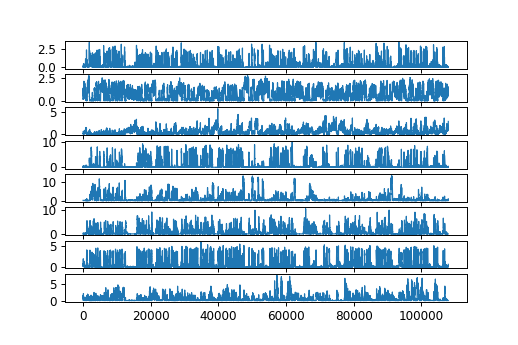

<IPython.core.display.Javascript object>


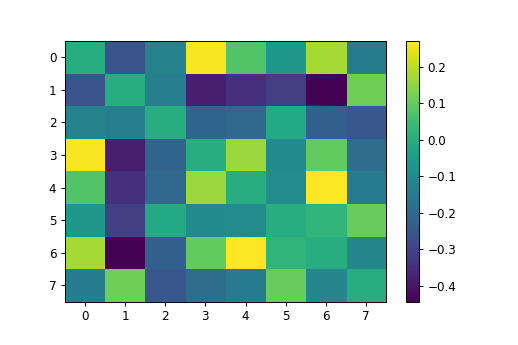

<IPython.core.display.Javascript object>


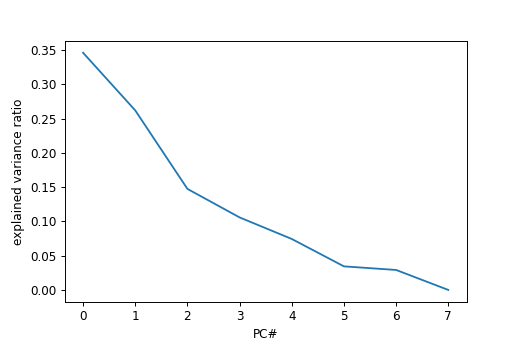

Text(0, 0.5, 'explained variance ratio')

In [101]:
%matplotlib notebook
repeat_toPlot = 0 # 0-indexed
rank_toPlot = 8 # 

rank_idx_toPlot = np.where(ranks==rank_toPlot)[0][0]
n_components = rank_toPlot
fig, axs = plt.subplots(n_components , sharex=True , sharey=False)
for ii in range(n_components):
    axs[ii].plot(fac_temp[rank_idx_toPlot][:,ii,repeat_toPlot] , linewidth=1)

plt.figure()
plt.imshow(np.corrcoef(fac_temp[rank_idx_toPlot][:,:,repeat_toPlot].T) - np.eye(n_components),aspect='auto')
plt.colorbar()

input_dimRed = fac_temp[rank_idx_toPlot][:,:,repeat_toPlot]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('PC#')
plt.ylabel('explained variance ratio')

In [219]:
def pairwise_similarity(vector_set1 , vector_set2 , method):
    from numpy.linalg import norm
    from scipy.stats import zscore
    
    if method=='pearson':
        output = (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2)
    if method=='R^2':
        output = ( (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2) )**2
    if method=='cosine_similarity':    
        output = (vector_set1 / (np.expand_dims(norm(vector_set1 , axis=0) , axis=0))).T  @ (vector_set2  / np.expand_dims(norm(vector_set2 , axis=0) , axis=0))
    return output

def similarity_2(mat1 , mat2 , method):
    import numpy as np
    '''
    This function compares the representations of two sets of vectors (columns of mat1 and columns of mat2).
    We assume that the vectors in mat1 and mat2 are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors
    
    Args:
        mat1 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat2
        mat2 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat1
        method (string)  : defines method of calculating pairwise similarity between vectors
        
    Returns:
        sim_avg (double)    : the average similarity between matched vectors. Units depend on method
        sim_matched (double): the similarity between each pair of matched vectors.
        ind1 (int)          : indices of vectors in mat1 matched to ind2 in mat2 (usually just sequential for ind1)
        ind2 (int)          : indices of vectors in mat2 matched to ind1 in mat1
    '''
    corr = mat1.T @ mat2
    ind1 , ind2 = scipy.optimize.linear_sum_assignment(corr, maximize=True)
    sim_matched = np.zeros(len(ind1))
    for ii in range(len(ind1)):
        if method=='pearson':
            sim_matched[ii] = np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1]
        if method=='R^2':
            sim_matched[ii] = (np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1])**2
        if method=='cosine_similarity':
            sim_matched[ii] = pairwise_similarity( mat1[:,ind1[ii]] , mat2[:,ind2[ii]] , 'cosine_similarity')

    sim_avg = np.mean(sim_matched)
    return sim_avg , sim_matched , ind1 , ind2

def self_similarity_pairwise(mat_set , method):
    '''
    This function compares sets of matrices using the similarity_2 function.
    We assume that the vectors within the matrices are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors within each matrix
    
    Args:
        mat_set (np.ndarray): a 3D array where the columns are vectors we wish to match with the columns of 
        method (string)     : defines method of calculating pairwise similarity between vectors

    Returns:
        same as similarity_2, but over each combo
        combos: combinations of pairwise comparisons
    '''
    
    import itertools

    n_repeats = mat_set.shape[2]
    n_components = mat_set.shape[1]

    combos = np.array(list(itertools.combinations(np.arange(n_repeats),2)))
    n_combos = len(combos)

    corr_avg = np.zeros((n_combos))
    corr_matched = np.zeros((n_components , n_combos))
    ind1 = np.zeros((n_components , n_combos))
    ind2 = np.zeros((n_components , n_combos))
    for i_combo , combo in enumerate(combos):
        corr_avg[i_combo] , corr_matched[:,i_combo] , ind1[:,i_combo] , ind2[:,i_combo]  =  similarity_2(mat_set[:,:,combo[0]]  ,  mat_set[:,:,combo[1]] , method)
    # print(corr_avg)
    return corr_avg, corr_matched, ind1, ind2, combos

In [ ]:
n_ranks = len(ranks)

corr_avg = list(np.zeros(n_ranks))
corr_matched = list(np.zeros(n_ranks))
ind1 = list(np.zeros(n_ranks))
ind2 = list(np.zeros(n_ranks))
combos = list(np.zeros(n_ranks))
corr_avg_mean = np.zeros(n_ranks)
corr_avg_std = np.zeros(n_ranks)


for i_rank, rank in enumerate(tqdm(ranks)):
    corr_avg[i_rank], corr_matched[i_rank], ind1[i_rank], ind2[i_rank], combos[i_rank] = self_similarity_pairwise(fac_temp[i_rank] , 'pearson')
    corr_avg_mean[i_rank] = np.mean(corr_avg[i_rank])
    corr_avg_std[i_rank] = np.std(corr_avg[i_rank])
    

In [64]:
rec_err_mean = np.zeros(n_ranks)
rec_err_std = np.zeros(n_ranks)
for i_rank, rank in enumerate(ranks):
    rec_err_mean[i_rank] = np.mean(rec_err[i_rank])
    rec_err_std[i_rank] = np.std(rec_err[i_rank])

<IPython.core.display.Javascript object>


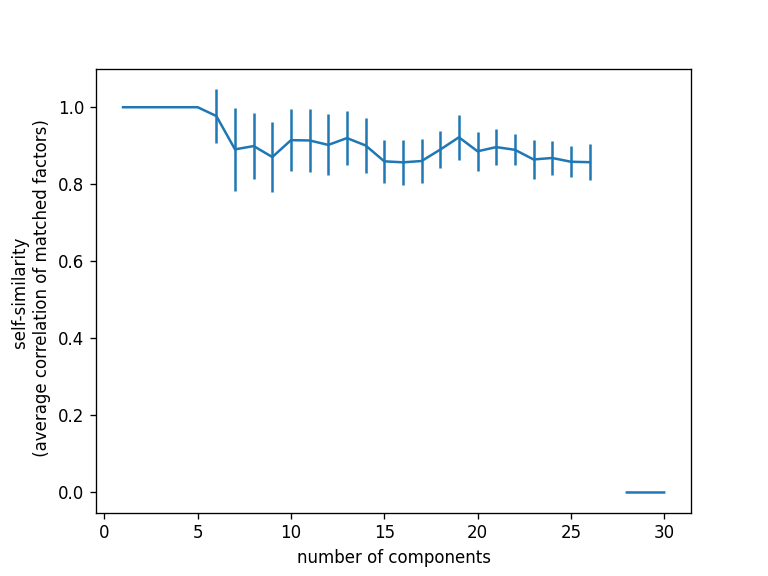

<IPython.core.display.Javascript object>


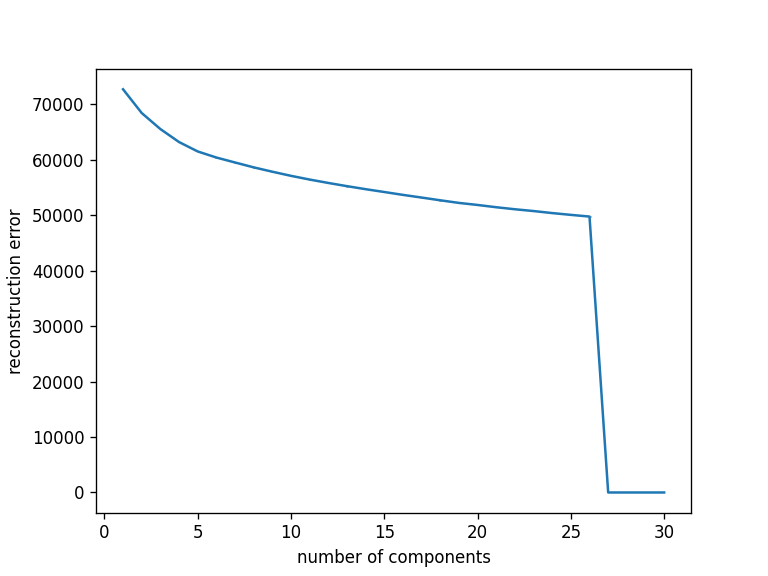

Text(0, 0.5, 'reconstruction error')

In [65]:
plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1,
             corr_avg_mean,
             yerr=corr_avg_std
            )
plt.xlabel('number of components')
plt.ylabel('self-similarity \n (average correlation of matched factors)')

plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1, rec_err_mean, yerr=rec_err_std)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')

In [66]:
all_comparisons = {
    "corr_avg": corr_avg,
    "corr_matched": corr_matched,
    "ind1": ind1,
    "ind2": ind2,
    "combos": combos,
}
summary_stats = {
    "rec_err_mean": rec_err_mean,
    "rec_err_std": rec_err_std,
}

alignment_outputs = {
    "all_comparisons": all_comparisons,
    "summary_stats": summary_stats,
}

from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_save = 'alignment_outputs'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , alignment_outputs)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis/alignment_outputs20210503.npy


In [36]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_load = 'alignment_outputs'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + today + fileSuffix_load)
# path_load = dir_load / fileName_load

alignment_outputs = np.load(path_load , allow_pickle=True)

alignment_outputs[()]['all_comparisons']['corr_avg']

corr_avg = alignment_outputs[()]['all_comparisons']['corr_avg']
corr_matched = alignment_outputs[()]['all_comparisons']['corr_matched']
ind1 = alignment_outputs[()]['all_comparisons']['ind1']
ind2 = alignment_outputs[()]['all_comparisons']['ind2']
combos = alignment_outputs[()]['all_comparisons']['combos']

rec_err_mean = alignment_outputs[()]['summary_stats']['rec_err_mean']
rec_err_std = alignment_outputs[()]['summary_stats']['rec_err_std']

In [32]:
# figure out which factors to use

In [35]:
fac_rank_toUse = 8 # actual value of rank
fac_repeat_toUse = 1 # 1-indexed repeat number

fac_rank_idx_toUse = np.where(ranks==fac_rank_toUse)[0][0]
fac_repeat_idx_toUse = fac_repeat_toUse-1

print(f' using model with rank = {fac_rank_toUse}, corresponding to rank index: {fac_rank_idx_toUse}, \n using repeat number: {fac_repeat_toUse}')\

fac_temp_toUse = fac_temp[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]
fac_neuron_toUse = fac_neuron[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]

 using model with rank = 8, corresponding to rank index: 0, 
 using repeat number: 1


Text(0.5, 0, 'aligned factor pair #')

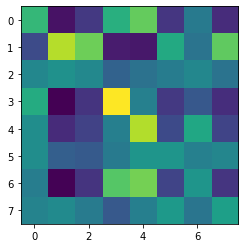

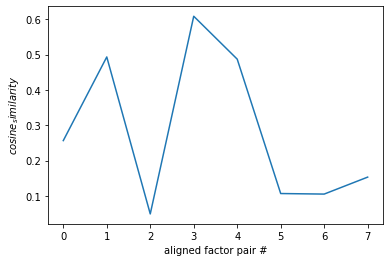

In [218]:
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
### correlate neural factors with behavioral factors

## first align the two sets of factors

# start with a cross-covariance matrix

method = 'cosine_similarity'

# vector_set1 = copy.deepcopy(fac_temp_toUse)
vector_set1 = copy.deepcopy(zscore(fac_temp_toUse,axis=0))
vector_set2 = copy.deepcopy(zscore(temporalFactors_s2pInd,axis=0))

xcorr_avg , xcorr_matched , xind1 , xind2  =  similarity_2(vector_set1  ,  vector_set2 , method)

sim_mat_aligned = pairwise_similarity(vector_set1[:,xind1] , vector_set2[:,xind2] , method)
aligned_diag = np.diag(sim_mat_aligned)
plt.figure()
plt.imshow(sim_mat_aligned)
plt.colorbar

plt.figure()
plt.plot(xcorr_matched)
plt.ylabel(f'${method}$')
plt.xlabel('aligned factor pair #')

<IPython.core.display.Javascript object>


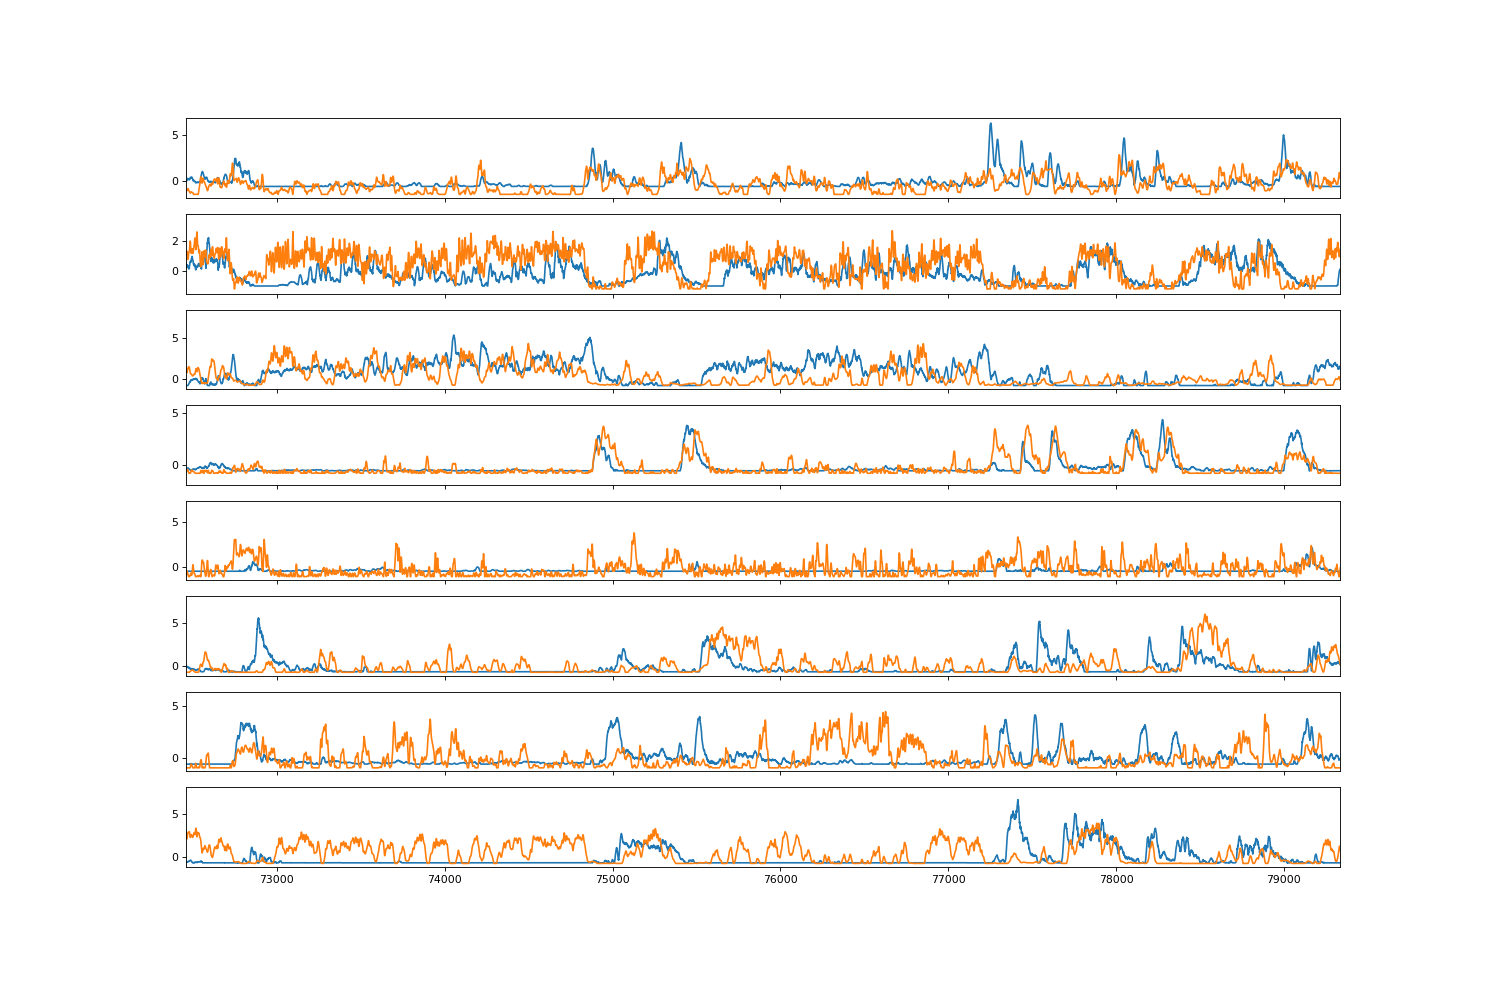

In [224]:
%matplotlib notebook

fig , axs = plt.subplots(vector_set1.shape[1] , sharex=True)
for ii in range(len(axs)):
    axs[ii].plot(vector_set1[:,xind1[ii]])
    axs[ii].plot(vector_set2[:,xind2[ii]])

In [107]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

cca = CCA(n_components=vector_set2.shape[1])
X_cc, Y_cc = cca.fit_transform(vector_set1, vector_set2)

In [108]:
pca = PCA(n_components=vector_set2.shape[1])
X_pc = pca.fit_transform(vector_set1)
X_pc_scree = pca.explained_variance_ratio_
Y_pc = pca.fit_transform(vector_set2)
Y_pc_scree = pca.explained_variance_ratio_

In [109]:
xcorr_mat_aligned = make_xcorrMat(X_cc , Y_cc)
R2_aligned_diag = np.diag(xcorr_mat_aligned)**2

Text(0.5, 0, 'component number')

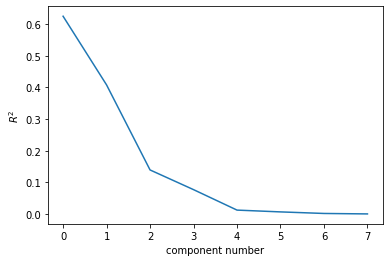

In [111]:
plt.figure()
plt.plot(R2_aligned_diag)
# plt.plot(X_pc_scree)
# plt.plot(Y_pc_scree)
plt.ylabel('$R^2$')
plt.xlabel('component number')

In [66]:
np.corrcoef(scipy.signal.savgol_filter(np.diff(X_cc[:,0]) , 31,3) , -scipy.signal.savgol_filter(np.diff(X_cc[:,1]) , 31,3))[0,1]**2

5.952432863288455e-05

<IPython.core.display.Javascript object>


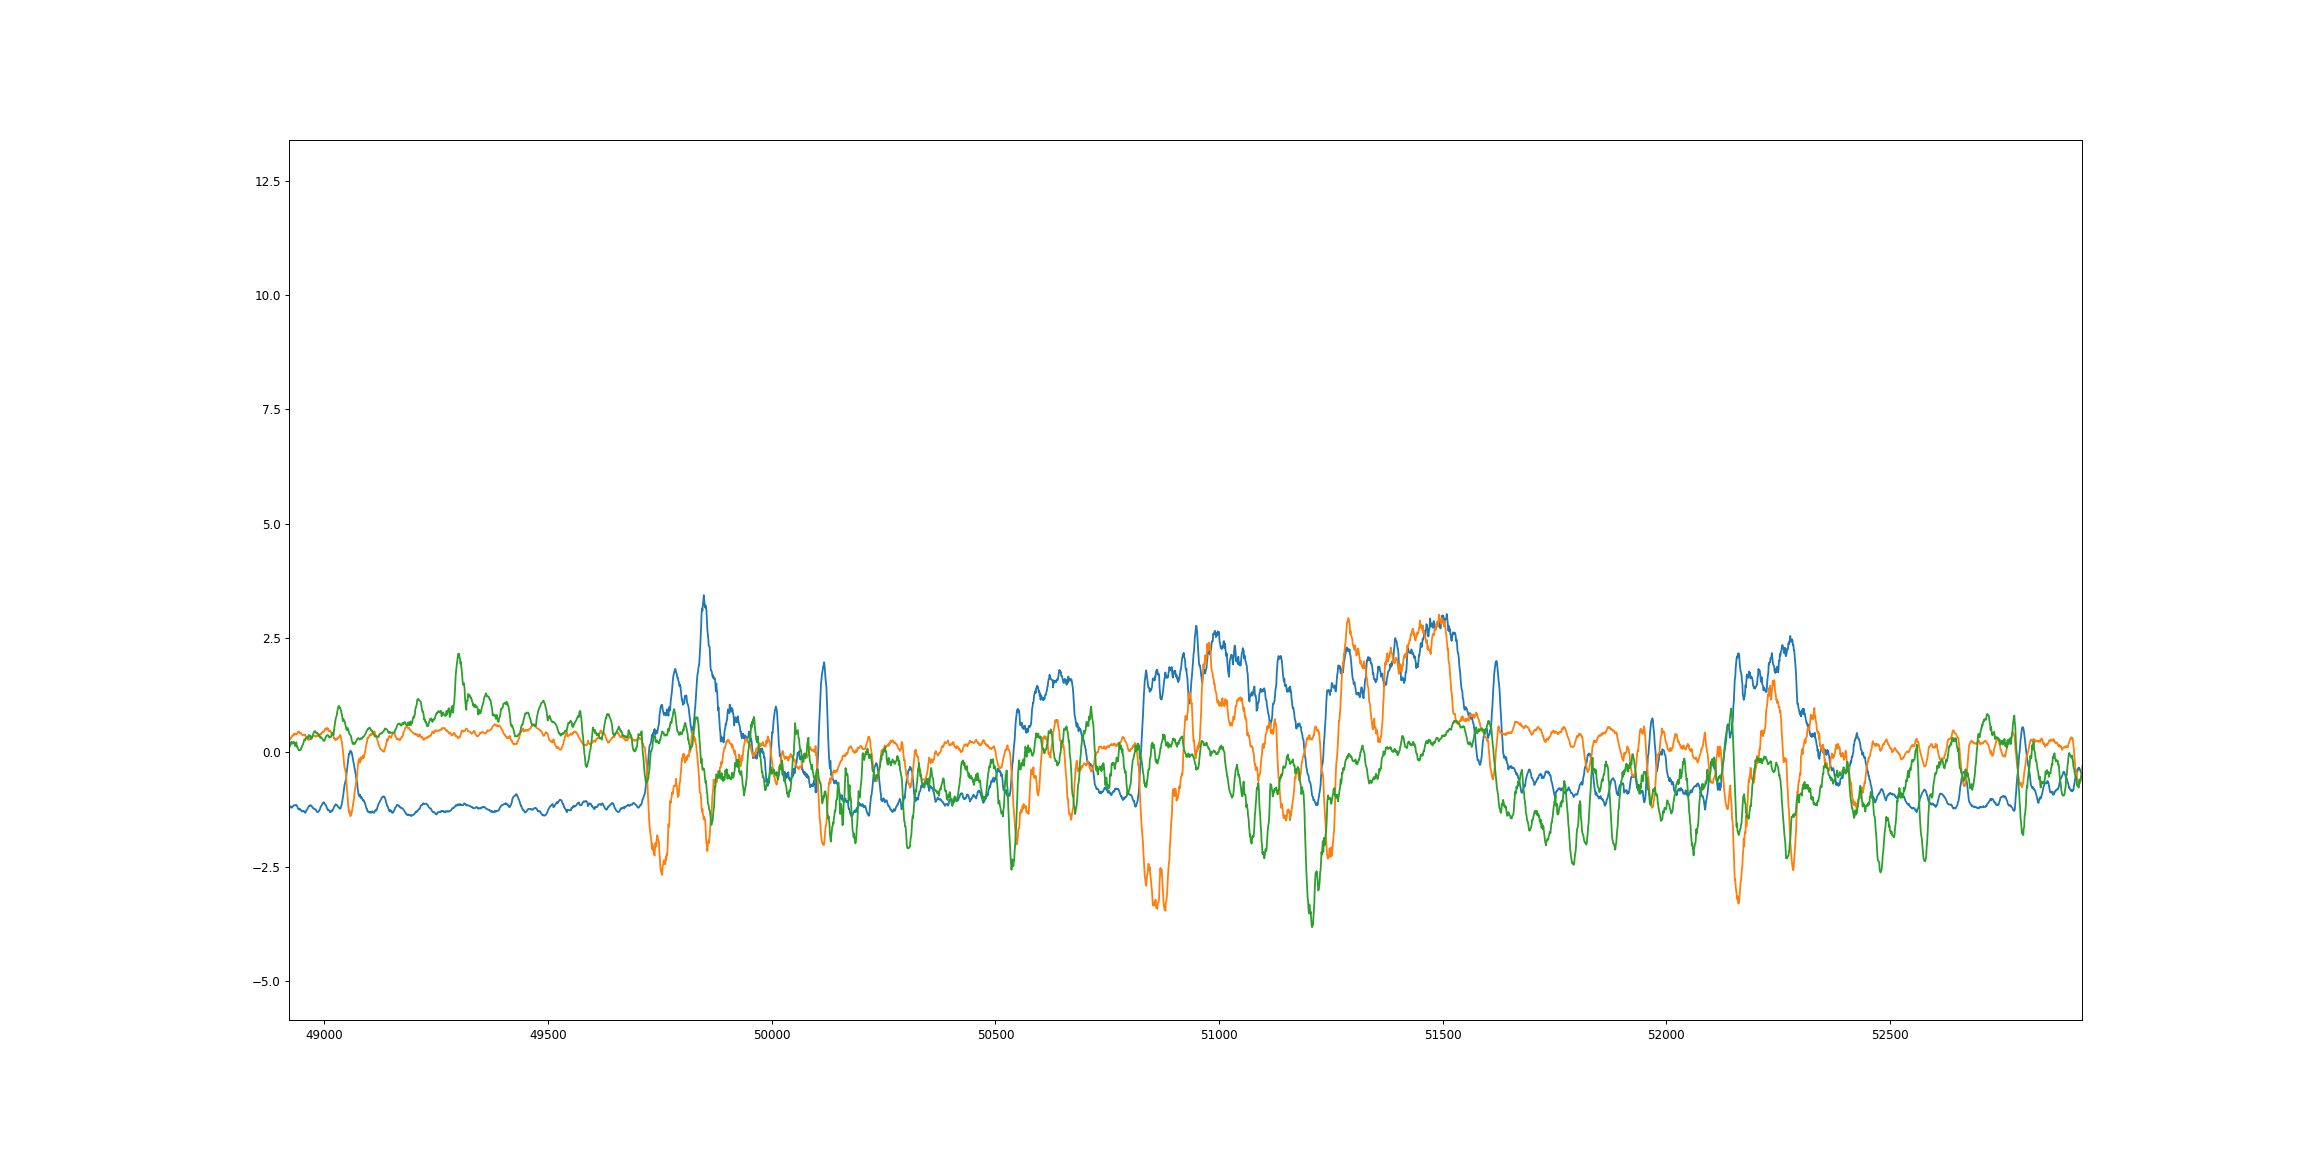

In [86]:
%matplotlib notebook
plt.figure()
plt.plot(X_cc[:,:3])
# plt.plot(scipy.signal.savgol_filter(np.diff(X_cc[:,0]) , 31,3))
# plt.plot(-scipy.signal.savgol_filter(np.diff(X_cc[:,1]) , 31,3))
# plt.plot(Y_c[:,0])
# plt.plot(-X_pc[:,1]/30)
# plt.plot(-Y_pc[:,0])


treadmill, train R: 0.8822762507831636
treadmill, test  R: 0.8772212840377442
R^2: 0.7695171811688287


<IPython.core.display.Javascript object>


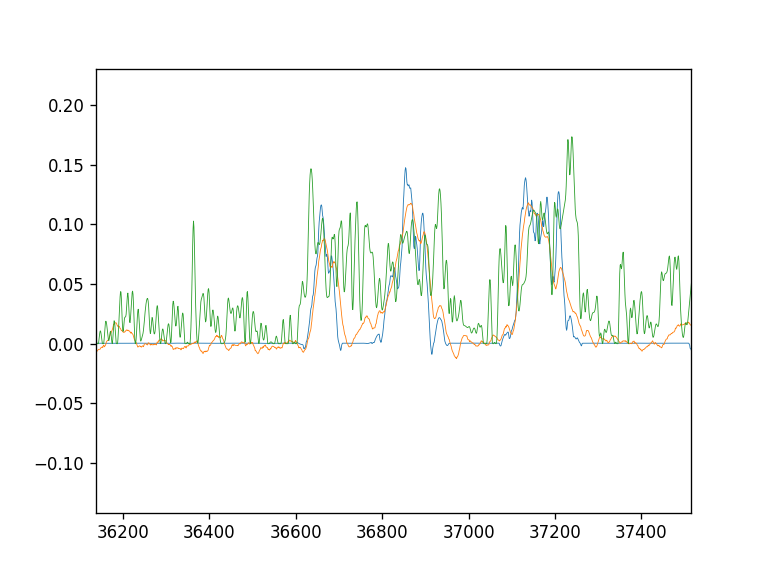

In [61]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,7]/10 , linewidth = 0.5)

treadmill, train R: 0.8471622646934773
treadmill, test  R: 0.8401484750669375


<IPython.core.display.Javascript object>


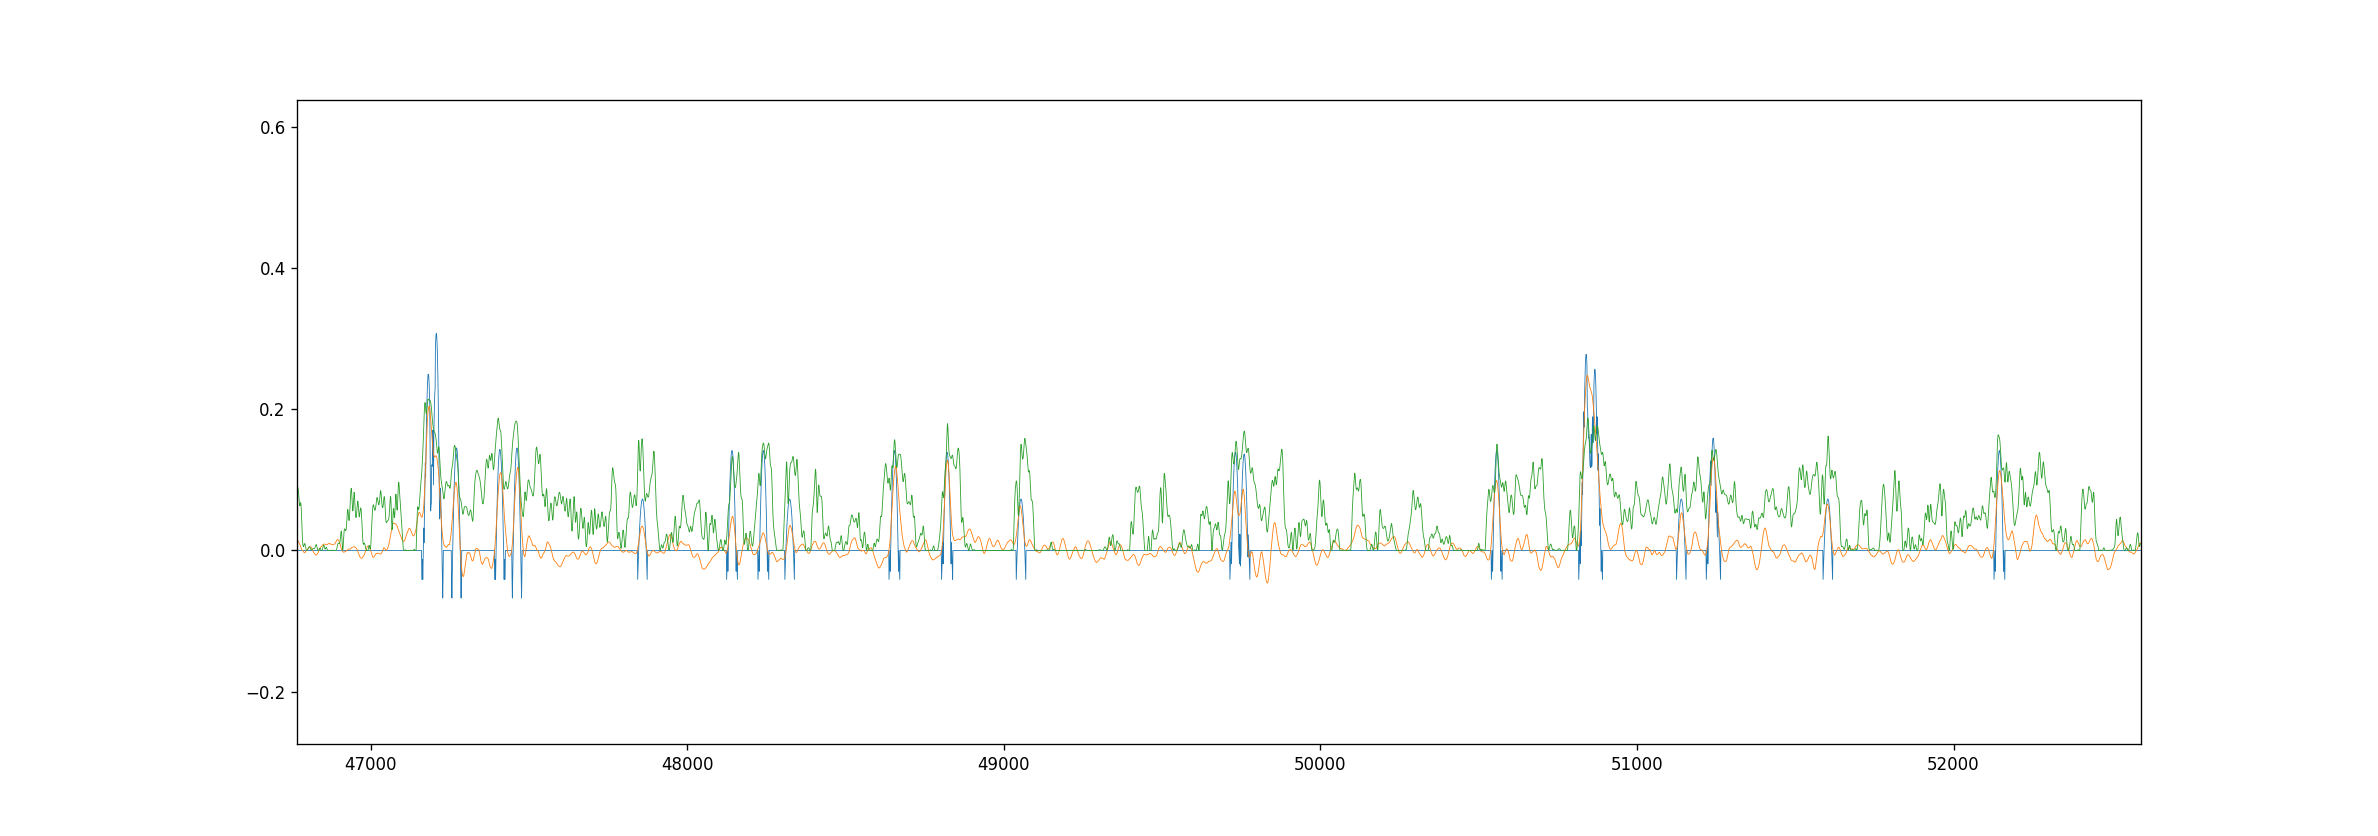

In [37]:
## Correlate to licking signal
# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = spks[IsCell_ROIClassifier==True,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,2]/10 , linewidth = 0.5)

In [39]:
theta_FF.shape
F_zscore_roll[:,IsCell_ROIClassifier==True].shape

(108000, 1005)

In [40]:
np.sum(IsCell_ROIClassifier)

1005

In [62]:
## Saving output ensembles
import scipy.io

factor_toUse_oneIdxed = 8

weights_RegressionAnalysisOutput = theta_FF[1:,factor_toUse_oneIdxed-1]

regression_output = {"regression_goalSignal": temporalFactors_s2pInd[:,factor_toUse_oneIdxed-1],
                     "regression_reconstruction":y_reconstructed_FF[:,factor_toUse_oneIdxed-1]
                    }

weights_day0 = {
  "weights": weights_RegressionAnalysisOutput,
  "iscell_custom": IsCell_ROIClassifier,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "factor_toUse_oneIdxed": factor_toUse_oneIdxed,
    "regression_output":regression_output,
}

dir_save = r'/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409'
save_name = 'weights_day0'
save_fullPath = f'{dir_save}{slash_type}weights_day0'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_day0)

np.save(f'{save_fullPath}.npy' , weights_day0)

<IPython.core.display.Javascript object>


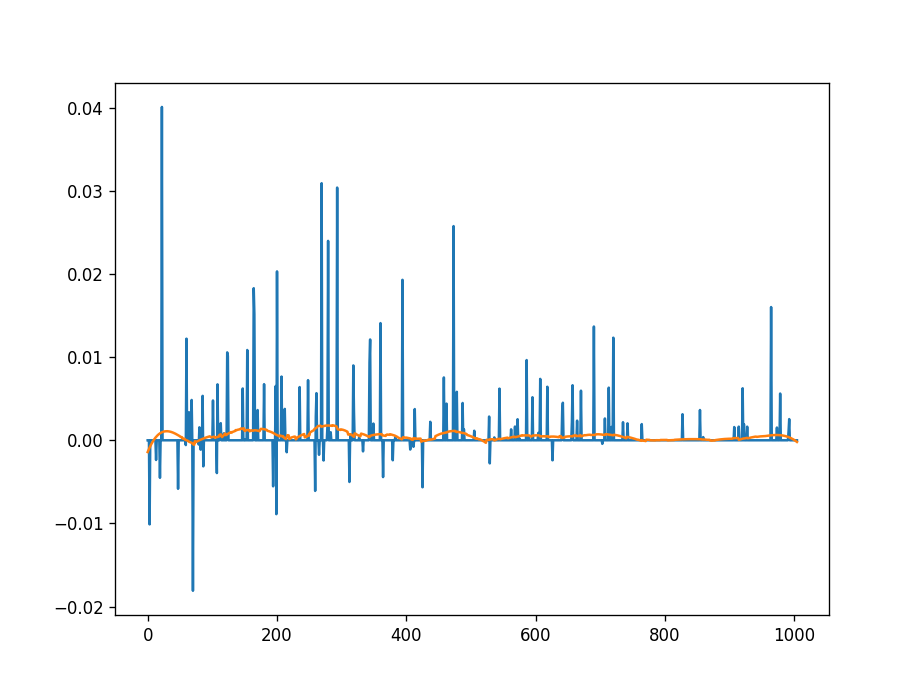

In [63]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3));